# Shay, Florrie & Sam's Data Science Project: MASTER NOTE BOOK
AKA The Data Science Project team of dreams 

# Introduction to the Project and Dataset


This project will analyse data from the Old Bailey Online dataset, which is the largest collection of historical trial records from London's central criminal court, containing approximately 197,745 trials from 1674 to 1913. The Old Bailey Proceedings document detailed accounts of criminal trials, including information about defendants, victims, offences, verdicts, and punishments. We obtained the dataset from the Old Bailey API at https://www.oldbaileyonline.org/.

Let's get started.

In [1]:
#Just importing some standard modules that we'll probably need.
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use ('fivethirtyeight')
import seaborn as sns
import pandas as pd
from scipy import stats
pd.set_option ('mode.copy_on_write', True)

# make sure you install the requirements.txt file to run this notebook!

# Data Acquisition and Cleaning

The Old Bailey's data is formatted through a variety of XML files. XML files are useful because they allow historical records to be stored in a structured, hierarchical format that preserves relationships between people and events and metadata. Which is important when you are trying to format your data in a way that you could look up certain statistics for the Old Bailey. Now, XML files are somewhat finicky unless you know how to clean them.

Now, calling the below "data cleaning" may seem slightly disingenuous given we are selectively extracting particular variables, as opposed to correcting errors in the data itself. But, I digress. 

The first thing we need to do is get our imports and installs sorted.


In [52]:
!pip install pandas
!pip install word2number

import xml.etree.ElementTree as ET # We need to import ElementTree to extract XML files, which is the file type the Old Bailey works with. 
# It will allow us to parse the XML files and directly pull their elements, as opposed to us using NLP (or something equally as troublesome)

from pathlib import Path # Pathlib will be important because we are analysing a LOT of XML files, and we'll need to be doing checks throughout to see if all is well

import pandas as pd
import csv
import re
from collections import Counter
from word2number import w2n


ModuleNotFoundError: No module named 'word2number'

Now, let's first just get all the files in one place and check we have all of them. Given the sheer quantity the Old Bailey database contains.

In [ ]:
input_dir = Path('.') # Given how many files we are working with, we can't actually keep the files in the GitHub. 
# As such, we are using the pathlib function just in case things end up breaking down across computers.

da_xml_files = list(input_dir.glob('*.xml')) 
# This will search the folder for all files ending with '.xml', thus finding all the files we need. 
# Listing them would be a bit problematic given how many there are. 
# It then creates a file called 'da_xml_files', which contains the name of all those files. 

print(f"Found {len(da_xml_files)} files") # This will double check how many files we have. 

## The Function of Time

Right, so, the most important piece of information we can extract from the XML files is the date of the various sessions. Without this, we won't be able to do much analysis at all as it all will be a function of time. So, we are going to create a function that extracts the session date and year from the tags within the files. 

In [ ]:
def if_i_could_put_time_in_a_dictionary(filepath):

    tree = ET.parse(filepath) # This will create an ElementTree object, which is how python essentially "sees" XML files
    root = tree.getroot() # This grabs the top-most tag for the XML files, and will help us find all the nested tags within it
    
    # Now we create empty strings for storage
    session_date = ""
    session_year = ""
    
    for div0 in root.iter('div0'): # The Old Bailey uses <div0> to mark top-level sections, like headers, cases, etc. So it's how we will split our data points by session as opposed to absorbing all of one XML file into a big mess

        if div0.get('type') == 'sessionsPaper': # This checks if the <div0> element has the attribute which is describing a court session with date and time. Otherwise, we're not interested. 

            for interp in div0.iter('interp'): # In Old Bailey, <interp> holds those elements like date, time, etc
                if interp.get('type') == 'date':
                    session_date = interp.get('value', '')
                elif interp.get('type') == 'year':
                    session_year = interp.get('value', '') # Note that Old Bailey stores year and date separately. So, we need to store them separately
            break
    
    if not session_year and len(session_date) >= 4: # Now, the data isn't perfect. So, if we are unable to extract the year, we can extract it from the title.
        session_year = session_date[:4] # The first four numbers are the year for Old Bailey
    
    return {'date': session_date, 'year': session_year}

# Now we run the function on our XML files, and print a couple to check its all worked! 
for xml_file in da_xml_files[:5]:
    filepath = input_dir / xml_file
    metadata = if_i_could_put_time_in_a_dictionary(filepath)
    print(f"{xml_file}: {metadata}")

## Getting Defendant Names (Like that one scene from Shawshank Redemption)

Now, we need to extract the data on a defendant basis, and get a list of names/IDs. The reason we are doing this is because we are interested in the data being on a by-defendant basis, as opposed to a by-trial or session basis. The reason for this is some trials may have more than one defendant, or we have every row being on a per-day basis. Which doesn't really work if you want to get into demographic data.  

Some information we want is their name, their id, and their gender. If we want to test any hypothesis relating to women, we will need this data.

In [ ]:
def dammit_dufresne_you_are_putting_me_behind(trial_elem):
    da_defendants = [] # Empty list to store defendant data
    
    # First, we'll create a loop that iterates over every XML name element within the trial element. 
    # Note that <persName> can be ANY name (defendant, witness, judge, etc), so we will need to do something about that
    for person in trial_elem.iter('persName'): 
        if person.get('type') == 'defendantName': # This will ensure we are only extracting defendants specifically
            def_id = person.get('id', '')
            
            given = ""
            surname = ""
            gender = ""
            
            # So, as we've established, the OldBailey XML files have tags for each defendant. 
            # It's actually quite amazing the work they've done because it is REALLY easy to extract if you know how
            # So, we create a for loop that will iterate over every value attribute (what stores defendant data) and assign the correct name and gender. 
            for interp in person.iter('interp'):
                inst = interp.get('inst')
                if inst == def_id:
                    interp_type = interp.get('type')
                    if interp_type == 'given':
                        given = interp.get('value', '')
                    elif interp_type == 'surname':
                        surname = interp.get('value', '')
                    elif interp_type == 'gender':
                        gender = interp.get('value', '')
            
            # Now, again, the Old Bailey data is HUGE and might not be perfect. 
            # So, just in case, we extract all the text content inside the <persName> element (which will be their name)
            # And we just put it in their name. 
            # It's not going to be perfect, but realistically, the name doesn't matter as much so we don't mind. 
            if not given and not surname:
                name_text = ''.join(person.itertext()).strip()
                given = name_text
            
            # Now we just create our dictionary and BOOM. All done. 
            da_defendants.append({
                'id': def_id,
                'given': given,
                'surname': surname,
                'gender': gender
            })
    
    return da_defendants

Now, let's run a quick test to make sure it all works.

In [ ]:
# Test on a particular file (when we first did this, we picked five files at random. The below file was one of those five, hence why its specific).
tree = ET.parse(input_dir / '18411129.xml')
root = tree.getroot()

count = 0 # We don't need to check all the trials within the file, so we'll set up a counter. 
for div1 in root.iter('div1'):
    if div1.get('type') == 'trialAccount':
        trial_id = div1.get('id')
        defs = dammit_dufresne_you_are_putting_me_behind(div1)
        print(f"{trial_id}: {defs}")
        count += 1
        if count >= 10: # End at 10 trials. Again, we don't need to waste time checking all of them. 
            break

Look there above. You can see some trials have more than one defendant. Thank god we decided to do this on a per-defendant basis, otherwise we would have been in trouble. Good luck Henry and Harriett with your trial (or rather, your t18411129)!

## What is the charge? Eating a meal? A succulent Chinese meal?

Well, defendant data is all well and good. But another key factor is the actual crime they committed, otherwise, this isn't really good court data. Thankfully, we can extract that pretty easily as well! Though, there is some further explanation we need to do before proceeding. 

See, Old Bailey breaks down crime and offence through specific categorisation. There is the Category and the Subcategory. The category is the broad type of crime committed in the trial, so the likes of theft, assault, murder, fraud, etc. The subcategory handles a more specific classification within that broad category, so for example, theft could specifically be burglary, pickpocketing, or shoplifting. Now, one thing to note is that crime definition changes over time, even over the time of decades. Hence why it is actually hard to compare temporal crime statistics (and why murder is usually very good as a baseline, because its definition rarely changes. Either you've been murdered or you haven't). 

It should be noted that some defendants don't have subcategories on their crimes, and that's fine. It's not strictly vital, and it's something that can be filtered later if necessary.


In [ ]:
# Right, so most of this stuff is the same again, so I won't go explaining everything. 
def i_am_offended(trial_elem):
    get_off_fences = [] # Offence dictionary storage
    
    for rs in trial_elem.iter('rs'): # Note we are using <rs> here and not <persName> because Old Bailey stores offence data inside <rs> elements
        # Specifically with type="offenceDescription"
        if rs.get('type') == 'offenceDescription':
            off_id = rs.get('id', '')
            category = ""
            subcategory = ""
            
            for interp in rs.iter('interp'):
                interp_type = interp.get('type')
                if interp_type == 'offenceCategory':
                    category = interp.get('value', '')
                elif interp_type == 'offenceSubcategory':
                    subcategory = interp.get('value', '')
            
            get_off_fences.append({
                'id': off_id,
                'category': category,
                'subcategory': subcategory
            })
    
    return get_off_fences

And there you have it. Now, we do the test once again to just check everything is working fine.

In [ ]:
tree = ET.parse(input_dir / '18411129.xml')
root = tree.getroot()

count = 0
for div1 in root.iter('div1'):
    if div1.get('type') == 'trialAccount':
        trial_id = div1.get('id')
        offs = i_am_offended(div1)  
        print(f"{trial_id}: {offs}")
        
        count += 1
        if count >= 10:  
            break

As a quick side. Theft Receiving means that the defendant knowingly accepted or bought goods that had been stolen; which is still a crime. Anyway, not important (truthfully speaking, I didn't know what it was and had to look it up. And I'm explaining it just in case).

We move on.

## 1000 counts of murder? To Arkham Asylum for the hundredth time with you! 

Right, and of course, we need the actual verdict and punishment, otherwise we have no value to the offences assigned to each defendant. After all, if they were all found innocent, then the Old Bailey dataset would be quite odd indeed. 

Once again, note there are subcategories. So, you can have guilty, not guilty as categories, and "guilty of theft" or "guilty of assault" as subcategories. Regarding punishment, categories work in the form of imprisonment -> 6 month imprisonment. So, the subcategories are actually important here and we will need to properly extract them. 

In [ ]:
# Again, same old stuff. 
def we_the_jury_find_this_code_to_be_awful(trial_elem):
    john_verdicts = []
    
    for rs in trial_elem.iter('rs'):
        if rs.get('type') == 'verdictDescription':
            ver_id = rs.get('id', '')
            category = ""
            subcategory = ""
            
            for interp in rs.iter('interp'):
                interp_type = interp.get('type')
                if interp_type == 'verdictCategory':
                    category = interp.get('value', '')
                elif interp_type == 'verdictSubcategory':
                    subcategory = interp.get('value', '')
            
            john_verdicts.append({
                'id': ver_id,
                'category': category,
                'subcategory': subcategory
            })
    
    return john_verdicts

def who_even_is_hammurabi_brah(trial_elem):
    arya_starks_list = [] # Storage for defendant punishments
    
    for rs in trial_elem.iter('rs'):
        if rs.get('type') == 'punishmentDescription':
            pun_id = rs.get('id', '')
            category = ""
            subcategory = ""
            
            for interp in rs.iter('interp'):
                interp_type = interp.get('type')
                if interp_type == 'punishmentCategory':
                    category = interp.get('value', '')
                elif interp_type == 'punishmentSubcategory':
                    subcategory = interp.get('value', '')
            
            arya_starks_list.append({
                'id': pun_id,
                'category': category,
                'subcategory': subcategory
            })
    
    return arya_starks_list

And once again, a quick test.

In [ ]:
tree = ET.parse(input_dir / '18411129.xml')
root = tree.getroot()

count = 0
for div1 in root.iter('div1'):
    if div1.get('type') == 'trialAccount':
        trial_id = div1.get('id')
        verd = we_the_jury_find_this_code_to_be_awful(div1)
        pun = who_even_is_hammurabi_brah(div1)
        
        print(f"{trial_id}:")
        print(f"  Verdicts: {verd}")
        print(f"  Punishments: {pun}")
        
        count += 1
        if count >= 10: 
            break

## Victim? I hardly know him.

Right, the next thing we are going to do is extract details of the victims of each trial, similarly to how we did the defendants. This is mostly because it could yield interesting data regarding what crimes were committed on whom. After all, say a hypothesis regarding women. It's important to know the crimes being committed AGAINST women as well as by them if we want to get the full picture.

In [ ]:
def get_victims_with_consent(trial_elem):
    whomst_wronged = []
    
    for person in trial_elem.iter('persName'):
        if person.get('type') == 'victimName':
            vic_id = person.get('id', '')
            
            given = ""
            surname = ""
            gender = ""
            
            for interp in person.iter('interp'):
                inst = interp.get('inst')
                if inst == vic_id:
                    interp_type = interp.get('type')
                    if interp_type == 'given':
                        given = interp.get('value', '')
                    elif interp_type == 'surname':
                        surname = interp.get('value', '')
                    elif interp_type == 'gender':
                        gender = interp.get('value', '')
            
            if not given and not surname: # As we did before with defendant names. This isn't always going to perfect. But we don't necessarily need it to be. 
                name_text = ''.join(person.itertext()).strip()
                given = name_text
            
            whomst_wronged.append({
                'id': vic_id,
                'given': given,
                'surname': surname,
                'gender': gender
            })
    
    return whomst_wronged

You know what comes next.

In [ ]:
tree = ET.parse(input_dir / '18411129.xml')
root = tree.getroot()

count = 0
for div1 in root.iter('div1'):
    if div1.get('type') == 'trialAccount':
        trial_id = div1.get('id')
        vics = get_victims_with_consent(div1)
        
        print(f"{trial_id}: Victims: {vics}")
        
        count += 1
        if count >= 10:  
            break

## Making Sense of the Madness

Now, where do we go from here? Well, we have huge lists with defendants and their crimes, victims, gender, the like. But the issue is that currently, they are all scattered about isolated. Each in their own list. What we need is code that will join this information together. We need to tell which defendant committed which offence, received which punishment, or which victims were affected. This is the process that will actually let us turn the scattered, raw XML into a dataset; in which each row can correspond to one instance of a defendant, potentially even for each of his/her/their crimes. 

In [ ]:
def join_together_wholesome(trial_elem):
    # First off, lets create a dictionary to store all the information. A super dictionary if you will. 
    wholesome_joins = {
        'criminalCharge': [],       # This will link the defendant to the offence and its verdict
        'defendantPunishment': [],  # This will link the defendant to the punishment
        'offenceVictim': [],        # This will link the defendant's offence to their victim
        'offencePlace': [],         # This will link the defendant's offence to the location in which it occurred
        'offenceCrimeDate': []      # # This will link the defendant's offence to the date it took place
    }
    
    for join in trial_elem.iter('join'): # This will loop over all <join> elements. These elements are in the Old Bailey XML
        # Basically, the Old Bailey team created <join> elements that link two entities together
        result = join.get('result', '')
        if result in wholesome_joins: # This will make sure to only keep joins that match the keys in the joins dictionary
            # Basically, we don't want to pair random cases together
            targets = join.get('targets', '').split()
            wholesome_joins[result].append({
                'id': join.get('id', ''),
                'targets': targets
            })
    
    return wholesome_joins


# Let's test this to actually make sure that it works. 
# We'll use the Dell case, which has a multi-defendant instance with multiple charges.
# If it works on this one, it'll work on all of them. 

tree = ET.parse(input_dir / '16791210.xml') # This is the file the Dell case is in. 
root = tree.getroot()

for div1 in root.iter('div1'):
    if div1.get('id') == 't16791210-10': # And this is the ID of the Dell case. 
        joins = join_together_wholesome(div1)
        print("Criminal charges (defendant -> offence -> verdict):")
        for j in joins['criminalCharge']:
            print(f"  {j['targets']}")
        print("\nDefendant punishments:")
        for j in joins['defendantPunishment']:
            print(f"  {j['targets']}")
        print("\nOffence victims:")
        for j in joins['offenceVictim']:
            print(f"  {j['targets']}")

# Let's see if it works.

And there you have it. It worked. You can see above that each list shows a link of defendant ID, offence ID, and verdict ID. This means the function successfully captured which defendant actually committed which offence and recieved what verdict. The following list has the punishment as well.

Now, one interesting thing to note is the offence victim list is empty. That is odd. It's likely the case that this particular case had no listed victims. That said, we should still look into it. 

Let's search for trials that specifically HAVE an offence-victim relationship (so a victim who is identified), and then see if the code works on that. If not, then we'll know something is wrong. 

In [ ]:
# We'll search the same file to see which cases have victim IDs linked to offences. 
tree = ET.parse(input_dir / '16791210.xml')
root = tree.getroot()

print("1679 file - offenceVictim joins:")
for div1 in root.iter('div1'):
    if div1.get('type') == 'trialAccount':
        joins = join_together_wholesome(div1)
        if joins['offenceVictim']:
            print(f"  {div1.get('id')}: {joins['offenceVictim']}")

And there you have it. All sorted. It's just that the Dell case didn't have any victims listed. 

As such, we can move on from here. 

## Crime Information Innit

I can't think of a funny, cultural reference to go with this section. Sorry.

Anyway, let's now make some functions to extract more information about each crime. As well as some more important information about the defendants, such as their age and occupation. 

In [ ]:
# Location of Crime
def WHERE_is_she(trial_elem):
    where_it_happenin = []
    
    for place in trial_elem.iter('placeName'):
        place_id = place.get('id', '')  
        place_name = ''.join(place.itertext()).strip()  
        place_type = ""
        
        for interp in place.iter('interp'):
            if interp.get('type') == 'type':
                place_type = interp.get('value', '')
        
        if place_type == 'crimeLocation':
            where_it_happenin.append({
                'id': place_id,
                'name': place_name
            })
    
    return where_it_happenin

# Date of Crime
def omg_crime_has_got_a_date(trial_elem):
    when_it_happenin = []
    
    for rs in trial_elem.iter('rs'):
        if rs.get('type') == 'crimeDate':
            when_it_happenin.append({
                'id': rs.get('id', ''),
                'date': ''.join(rs.itertext()).strip()
            })
    
    return when_it_happenin


# Onto Defendant Occupation
# I am going to do a brief explanation for this one as functionally, it is different to the previous ones
# Our previous functions worked off a "give me everything related to X within a certain trial"
# This code below functions moreso as "GIVEN this defendant, what is their occupation?"
# The key is the <join> element. As before, it is searching for related pieces of information that are connected via <join>

def get_a_job(trial_elem, defendant_id):
    for join in trial_elem.iter('join'):
        if join.get('result') == 'persNameOccupation': # This makes sure all other joins except occupation are ignored
            targets = join.get('targets', '').split() # Get the IDs the <join> links together
            if defendant_id in targets: # Checks if the defendant is relevant to the relationship. If not, skip.
                for target in targets: # Loop over each linked ID (defendant + occupation)
                    for rs in trial_elem.iter('rs'): # Look through all <rs> elements in the trial
                        # The reason we are doing this is because the <join> tag only tells us which IDs are related
                        # It doesn't tell is where the actual text is that says what their job is
                        if rs.get('id') == target and rs.get('type') == 'occupation': # That's what this code does below
                            return ''.join(rs.itertext()).strip()
    return ""

# Defendant Age
# This is similar to occupation
def how_old_are_you(trial_elem, defendant_id):
    """Find age for a specific defendant."""
    for person in trial_elem.iter('persName'):
        if person.get('id') == defendant_id:
            for interp in person.iter('interp'):
                if interp.get('type') == 'age':
                    return interp.get('value', '')
    return ""

Let's do some quick tests.

In [ ]:
tree = ET.parse(input_dir / '16931012.xml')
root = tree.getroot()

count = 0
for div1 in root.iter('div1'):
    if div1.get('type') == 'trialAccount':
        trial_id = div1.get('id')
        locs = WHERE_is_she(div1)
        dates = omg_crime_has_got_a_date(div1)
        
        if locs or dates:  # Makes sure we only print trials at least one location or date
            print(f"{trial_id}:")
            if locs:
                print(f"  Locations: {locs}")
            if dates:
                print(f"  Dates: {dates}")
            count += 1
            if count >= 10:  
                break

Now hold on, the location doesn't appear to be extracted by our code. Let's try a test on all the XML files to see if its an issue that that particular file simply doesn't have locations within it. The code below will find the first XML file that has a viable location. 

In [ ]:
found = False

for xml_file in da_xml_files:
    filepath = input_dir / xml_file
    tree = ET.parse(filepath)
    root = tree.getroot()
    
    for div1 in root.iter('div1'):
        if div1.get('type') == 'trialAccount':
            locations = WHERE_is_she(div1)
            if locations:
                print(f"Found location in {xml_file}, trial {div1.get('id')}: {locations}")
                found = True
                break  # Stop after first location in this file
    if found:
        break  # Stop after finding first location in all files

if not found:
    print("No crime locations found in any file.")

Stoke Newington of all places. God forbid the land of the gentrified today experiences such crimes. Anyway, let's test that file specifically to see if it all works.

In [ ]:
tree = ET.parse(input_dir / '17151012.xml')
root = tree.getroot()

count = 0
for div1 in root.iter('div1'):
    if div1.get('type') == 'trialAccount':
        trial_id = div1.get('id')
        locs = WHERE_is_she(div1)
        dates = omg_crime_has_got_a_date(div1)
        
        if locs and dates:  # We'll briefly change this to 'and' so we can actually pull up good ones. 
            print(f"{trial_id}:")
            if locs:
                print(f"  Locations: {locs}")
            if dates:
                print(f"  Dates: {dates}")
            count += 1
            if count >= 50:  
                break

## David Lammy would have this section not exist

Right, now we are going to extract our last direct piece of information (there is one more thing that is less direct but we'll go into that later). Judge and Jury information. This is important because if we potentially want to run any hypothesis about bias in the judicial system historically, you will need to see patterns will specific jurors and judges. 

So, we are going to extract those on a per-offence basis, and it will be quite interesting to see later if any judges have any particular predilection towards a certain punishment.

In [ ]:
def its_too_late_i_have_already_depicted_you_as_the_buffoonish_juror_three_and_myself_as_the_unbothered_and_collected_juror_twelve(root): # I am not sorry for referencing 12 Angry Men. Good film. You should watch it
    # I am maybe alightly sorry about the length of that function name lol
    chewbacca_defence = []
    for person in root.iter('persName'):
        if person.get('type') == 'jurorName':
            juror_id = person.get('id', '')
            given = ""
            surname = ""
            for interp in person.iter('interp'):
                if interp.get('type') == 'given':
                    given = interp.get('value', '')
                elif interp.get('type') == 'surname':
                    surname = interp.get('value', '')
            chewbacca_defence.append({
                'id': juror_id,
                'name': f"{given} {surname}".strip()
            })
    return chewbacca_defence

def someones_judgy(root):
    fudges = []
    for person in root.iter('persName'):
        if person.get('type') == 'judiciaryName':
            judge_id = person.get('id', '')
            given = ""
            surname = ""
            for interp in person.iter('interp'):
                if interp.get('type') == 'given':
                    given = interp.get('value', '')
                elif interp.get('type') == 'surname':
                    surname = interp.get('value', '')
            fudges.append({
                'id': judge_id,
                'name': f"{given} {surname}".strip()
            })
    return fudges


Test. Test. Test.

In [ ]:
tree = ET.parse(input_dir / '17840707.xml')
root = tree.getroot()

jurors = its_too_late_i_have_already_depicted_you_as_the_buffoonish_juror_three_and_myself_as_the_unbothered_and_collected_juror_twelve(root)
judges = someones_judgy(root)

print(f"Jurors ({len(jurors)}):")
for j in jurors[:5]:
    print(f"  {j}")

print(f"\nJudges ({len(judges)}):")
for j in judges[:5]:
    print(f"  {j}")

## You see, four Farthings make a Halfpenny, and two Halfpennies make one Penny, and four Pence make a Groat, and three Groat make a Shilling, and five Shillings make a Pou- oh, you get the point...
---
## TLDR, this section is about money

Sean_Bean_Money.mp3. Anyway, money is being handled differently because it is not explicitly tagged in the XML file like defendants or offences are. So, instead of reading structured <rs> or <persName> elements, we must generate code that searches the raw text files for patterns like "26 s" or "6 d". Basically, we need to perform a bit of regex. Which does open us up to errors, but we don't have to be absolutely perfect with the code either. 

Now, we can't just pull from all the text as then we'd have the issue of including things like fines, wages, etc. What we want is the stolen value and the fined value only. Luckily, Old Bailey contains stolen value in the OffenceDescription element, so we can search specifically there to filter out all the other money nonsense.

Time to parse that free text of the Old Bailey and see if we can get this to work!

In [ ]:
# The first thing we need to do is find what the Old Bailey actually uses for currency. We don't any curveballs like marks or something. Or Groats. 

what_currencies = Counter()

for filepath in da_xml_files:
    tree = ET.parse(filepath)
    root = tree.getroot()
    
    text = ''.join(root.itertext())
    
    strike_matches = re.findall(r'\d+\s*([a-zA-Z]{1,10})\.', text)
    for m in strike_matches:
        what_currencies[m.lower()] += 1

print("Most common patterns (number followed by letters then period):")
for pattern, count in what_currencies.most_common(50):
    print(f"  {pattern}: {count}")

Aha! As we can see, our most common ones are shillings, pounds, pence, and guineas. Now, given the "offenceDescription" element only contains monetary reference to stealing, we can thus make code to count this up. Note however, that someone may steal money AND an item valued at a certain amount. So, we need to add that together into a total monetary value that was stolen. 

In [ ]:
def wheres_the_money_lebowski(trial_elem):
    # First, we need to combine all the text inside the offenceDescription tags so we can search it
    text = ""
    for rs in trial_elem.iter('rs'):
        if rs.get('type') == 'offenceDescription':
            text += ' ' + ''.join(rs.itertext())
    
    pounds = 0 
    shillings = 0
    pence = 0
    guineas = 0 
    # We are using integers now so we can add multiple values
    
    # Pound search 
    pound_matches = re.findall(r'(\d+)\s*l\.', text) # Note that l. (from Latin's libra) is the old abbreviation for Pounds, not the £ we know and love.
    for match in pound_matches:
        pounds += int(match)
    
    pound_word_matches = re.findall(r'(\d+)\s*pounds?', text, re.IGNORECASE) # Catch pounds in words. 
    for match in pound_word_matches:
        pounds += int(match)
    
    # Shilling search 
    shilling_matches = re.findall(r'(\d+)\s*s\.', text) # Shilling is s. (from Latin's solidus)
    for match in shilling_matches:
        shillings += int(match)
    
    shilling_word_matches = re.findall(r'(\d+)\s*shillings?', text, re.IGNORECASE) 
    for match in shilling_word_matches:
        shillings += int(match)
    
    # Pence search 
    pence_matches = re.findall(r'(\d+)\s*d\.', text) # Pence is d. (from Latin's denarius)
    for match in pence_matches:
        pence += int(match)
    
    pence_word_matches = re.findall(r'(\d+)\s*pence', text, re.IGNORECASE) # Make sure we also catch things like "6 pence"
    for match in pence_word_matches:
        pence += int(match)
    
    # Guinea search
    guinea_matches = re.findall(r'(\d+)\s*guineas?', text, re.IGNORECASE)
    for match in guinea_matches:
        guineas += int(match)
    
    return pounds, shillings, pence, guineas

Let's do a quick test to see if this shambolic attempt at code actually works.

In [ ]:
tree = ET.parse(input_dir / '16931012.xml')
root = tree.getroot()

count = 0
for div1 in root.iter('div1'):
    if div1.get('type') == 'trialAccount':
        trial_id = div1.get('id')
        pounds, shillings, pence, guineas = wheres_the_money_lebowski(div1)
        if pounds or shillings or pence or guineas:
            print(f"{trial_id}: {pounds} pounds, {shillings} shillings, {pence} pence, {guineas} guineas")
            count += 1
            if count >= 10:
                break

Alright! It worked. Now we can do the same for fines, which luckily is only in the "punishmentDescription" tag. In fact, fines can only be found in the subcategory to the 'fine' category in general, so it is really easy for us to get those numbers. On the flip side, they spell the word "value" incorrectly multiple times, so we should avoid a regex with that word.

We also are going to include "Marks" for fines, which was a non-codified unit of currency in Britain. I saw it in one or two fines so we may as well be certain. 

In [ ]:
def damn_you_fine(trial_elem):
    # Search only within punishmentDescription tags that are specifically fines. 
    # Very similar to how we did before with the <rs> element. 

    text = ""
    for rs in trial_elem.iter('rs'):
        if rs.get('type') == 'punishmentDescription':
            # Check if this is a fine
            for interp in rs.iter('interp'):
                if interp.get('type') == 'punishmentSubcategory' and interp.get('value') == 'fine':
                    text += ' ' + ''.join(rs.itertext())
                    break
    
    fine_pounds = 0
    fine_shillings = 0
    fine_pence = 0
    fine_guineas = 0
    fine_marks = 0
    
    # Pounds 
    for match in re.findall(r'(\d+)\s*l\.', text):
        fine_pounds += int(match)
    for match in re.findall(r'(\d+)\s*pounds?', text, re.IGNORECASE):
        fine_pounds += int(match)
    
    # Shillings
    for match in re.findall(r'(\d+)\s*s\.', text):
        fine_shillings += int(match)
    for match in re.findall(r'(\d+)\s*shillings?', text, re.IGNORECASE):
        fine_shillings += int(match)
    
    # Pence 
    for match in re.findall(r'(\d+)\s*d\.', text):
        fine_pence += int(match)
    for match in re.findall(r'(\d+)\s*pence', text, re.IGNORECASE):
        fine_pence += int(match)
    
    # Guineas
    for match in re.findall(r'(\d+)\s*guineas?', text, re.IGNORECASE):
        fine_guineas += int(match)
    
    # Marks
    for match in re.findall(r'(\d+)\s*marke?s?', text, re.IGNORECASE):
        fine_marks += int(match)
    
    return fine_pounds, fine_shillings, fine_pence, fine_guineas, fine_marks

And a quick test code!

In [ ]:
count = 0
for filepath in da_xml_files:
    if count >= 15:
        break
    tree = ET.parse(filepath)
    root = tree.getroot()
    
    for div1 in root.iter('div1'):
        if count >= 15:
            break
        if div1.get('type') == 'trialAccount':
            pounds, shillings, pence, guineas, marks = damn_you_fine(div1)
            if pounds or shillings or pence or guineas or marks:
                print(f"{trial_id}: {pounds} pounds, {shillings} shillings, {pence} pence, {guineas} guineas, {marks} marks")
                count += 1

Awesome, awesome! We got that all to work perfectly! Now, let's move on. 

## Code of Hammurabi or something, idk I didn't watch the movie

Right, now onto our last issue. Imprisonment time isn't something that can be directly extracted either. So, we will need to do that similarly to the money amounts in order to see for how LONG someone was imprisoned. 

In [ ]:
def five_HUNDRED_life_sentences(trial_elem):
    text = ""
    for rs in trial_elem.iter('rs'): # This is very similar to before. We are searching the <rs> element for the imprison subcategory
        if rs.get('type') == 'punishmentDescription':
            for interp in rs.iter('interp'):
                if interp.get('type') == 'punishmentCategory' and interp.get('value') == 'imprison':
                    text += ' ' + ''.join(rs.itertext()) # This will add the full text of our <rs> element to our text string, meaning we can analyse it.
                    # I might have already explained what that line does in a previous function but uh
                    # My memory is going ngl
                    break
    
    # Some common misspellings I found in the XML files. We are likely to miss some. 
    # More can be added if we discover more. 
    minor_spelling_mistake = {
        'tweleve': 'twelve',
        'bight': 'eight',
        'pour': 'four'
    }
    
    # I ran some code as to find the words which provide the most noise. 
    # This will allow us to exclude them. 
    # As with the spelling mistakes, we can add more should it become an issue. But given we have so MANY trials and so little errors
    # We shouldn't need to worry
    noise = ['last', 'calendar', 'calender', 'each', 'first', 'there', 'sir', 'fine', 'the', 'a', 'an']
    

    # First we find numbers that are followed by a time unit, making sure we actually ignore case specific language
    match = re.search(r'([a-zA-Z\-]+|\d+)\s*(month|year|week|day)s?', text, re.IGNORECASE)
    if match:
        num_str = match.group(1).lower()
        unit = match.group(2).lower() # If we find one, we extract the number and the unit and convert them both to lower case
        
        # This will fix the three common spelling mistakes we found. 
        if num_str in minor_spelling_mistake:
            num_str = minor_spelling_mistake[num_str] 
        
        # Skip the common noise words, we don't need them
        if num_str in noise:
            return ""
        
        # Now we use the word2number import to convert them and bam. We done. 
        try:
            if num_str.isdigit():
                num = int(num_str)
            else:
                num = w2n.word_to_num(num_str)
            return f"{num} {unit}s"
        except:
            return ""
    
    return ""


It's the FINAL test. Hell yeah, I am sick of writing these.

In [ ]:
count = 0
for filepath in da_xml_files:
    if count >= 15:
        break
    tree = ET.parse(filepath)
    root = tree.getroot()
    
    for div1 in root.iter('div1'):
        if count >= 15:
            break
        if div1.get('type') == 'trialAccount':
            duration = five_HUNDRED_life_sentences(div1)
            if duration:
                print(f"{filepath.name} - {div1.get('id')}: {duration}")
                count += 1

It WORKS. Let's gooooooooooooo. 

Now, let's bring it all together into one big place.

## Bringing It All Together

We are at the end of our XML journey, sorry kids. But it was quite fun, if not finnicky. Now, lets create one last function that takes everything we've done and uses all our tested functions. After that, we shall convert it to a csv and actually perform analysis on it. Further data cleaning will have to be performed on an adhoc basis (for example, fixing case elements or adding something like the population of London for each year). This also includes things like converting to date-time, if needed. The main function of this portion was just extracting the data correctly from the XML files.

Anyway, let us commence forth.

In [ ]:
def ITS_THE_FINAL_FUNCTION_DA_DA_DA_DAAAAAAA(trial_elem, session_date, session_year, juror_ids, judge_ids):
    # The reason why these particular parameters have been chosen need a brief explanation
    # trial_elem is the XML <div1> element, and that gets us all the data involved in that trial
    # the two time functions come from the metadata
    # juror and judge IDs are session-level data, as most trials in a general session share the same jurors and judges
    rows = []
    
    trial_id = trial_elem.get('id', '')
    
    # And here are all our schizophrenic function names. 
    # <3
    defendants = dammit_dufresne_you_are_putting_me_behind(trial_elem)
    victims = get_victims_with_consent(trial_elem)
    offences = i_am_offended(trial_elem)
    verdicts = we_the_jury_find_this_code_to_be_awful(trial_elem)
    punishments = who_even_is_hammurabi_brah(trial_elem)
    joins = join_together_wholesome(trial_elem)
    crime_dates = omg_crime_has_got_a_date(trial_elem)
    crime_locations = WHERE_is_she(trial_elem)
    
    # Here are the variables for stolen and fined monetary values using our functions
    pounds, shillings, pence, guineas = wheres_the_money_lebowski(trial_elem)
    fine_pounds, fine_shillings, fine_pence, fine_guineas, fine_marks = damn_you_fine(trial_elem)

    # And this is for the length of imprisonment if the punishment is said imprisonment
    imprisonment_length = five_HUNDRED_life_sentences(trial_elem)
    
    # Now we need to provide defaults should the XML be missing information
    # What we are doing is creating a placeholder dictionary should there be no defendants or offences in the file
    # It is mostly there to prevent errors when the loop encounters those empty fields
    if not defendants:
        defendants = [{'id': '', 'given': '', 'surname': '', 'gender': ''}]
    if not offences:
        offences = [{'id': '', 'category': '', 'subcategory': ''}] 
    
    for defendant in defendants:
        def_occupation = get_a_job(trial_elem, defendant['id'])
        def_age = how_old_are_you(trial_elem, defendant['id'])
        
        # Now, all of the below is nested within the defendant information we pulled from the above lines of code
        # The reason for this is that a trial can have multiple defendants
        # And each defendant can be associated with multiple victims
        # And they can commit multiple offences, be partial to multiple punishments, etc
        # So, we need to loop through each variable (offences, punishment, etc) based on every defendant

        for offence in offences: # So, this is our second loop. 
            # A defendant can commit multiple crimes, and be found innocent and/or guilty for different charges
            # Loop in a loop!

            # Here, we find the verdict. 
            # We do this through the <join> element, in which a verdict is linked to a defendant-offence combination
            # Without it, our CSV generation could miss verdict information
            # Or it could even misattribute a verdict to the wrong offence
            verdict_cat, verdict_sub = "", ""
            for join in joins['criminalCharge']:
                if defendant['id'] in join['targets'] and offence['id'] in join['targets']:
                    for target in join['targets']:
                        for v in verdicts:
                            if v['id'] == target:
                                verdict_cat = v['category']
                                verdict_sub = v['subcategory']
                                break
            #  And here, we create a fallback. 
            # If we CANNOT find a match, we take the first verdict in the trial
            # This makes sure we always have some value instead of leaving it blank
            # As some trials just do 1 general verdict for all defendants
            # They are so silly in the past aren't they. Not like us here in the present.
            # We're so smart unlike them /s
            if not verdict_cat and verdicts:
                verdict_cat = verdicts[0]['category']
                verdict_sub = verdicts[0]['subcategory']
            
            # Same but for punishment
            punishment_cat, punishment_sub = "", ""
            for join in joins['defendantPunishment']:
                if defendant['id'] in join['targets']:
                    for target in join['targets']:
                        for p in punishments:
                            if p['id'] == target:
                                punishment_cat = p['category']
                                punishment_sub = p['subcategory']
                                break
            # Note that some trials just do a sweeping punishment
            # So, we will fill these in with the general punishment
            if not punishment_cat and punishments:
                punishment_cat = punishments[0]['category']
                punishment_sub = punishments[0]['subcategory']
            
            # Same but for victim gender
            victim_gender = ""
            for join in joins['offenceVictim']:
                if offence['id'] in join['targets']:
                    for target in join['targets']:
                        for v in victims:
                            if v['id'] == target:
                                victim_gender = v['gender']
                                break
                            # Note that here, we are not going to fill in any blanks
                            # That's becasuse it makes no sense. Not knowing the gender of one victim doesn't mean you know the gender of the other
                            # Unlike the other loops, there is no case to perform a data extrapolation here
            
            # Same but for crime date
            crime_date = ""
            for join in joins['offenceCrimeDate']:
                if offence['id'] in join['targets']:
                    for target in join['targets']:
                        for cd in crime_dates:
                            if cd['id'] == target:
                                crime_date = cd['date']
                                break
            if not crime_date and crime_dates:
                crime_date = crime_dates[0]['date']
            
            # Notice this one is different. 
            # Every trial usually only has one location in which crime was committed
            # Basically, we don't need to worry about this one at all
            crime_location = ""
            if crime_locations:
                crime_location = crime_locations[0]['name']
            
            # This combines the first name and last name of the defendant
            # Just because I don't want an extra column that's just for first and last name
            def_name = f"{defendant['given']} {defendant['surname']}".strip()
            
            row = {
                'session_date': session_date,
                'session_year': session_year,
                'trial_id': trial_id,
                'defendant_name': def_name,
                'defendant_gender': defendant['gender'],
                'defendant_age': def_age,
                'defendant_occupation': def_occupation,
                'victim_gender': victim_gender,
                'offence_category': offence['category'],
                'offence_subcategory': offence['subcategory'],
                'verdict': verdict_cat,
                'verdict_detail': verdict_sub,
                'punishment': punishment_cat,
                'punishment_detail': punishment_sub,
                'imprisonment_length': imprisonment_length,
                'crime_location': crime_location,
                'crime_date': crime_date,
                'offence_value_pounds': pounds,
                'offence_value_shillings': shillings,
                'offence_value_pence': pence,
                'offence_value_guineas': guineas,
                'fine_value_pounds': fine_pounds,
                'fine_value_shillings': fine_shillings,
                'fine_value_pence': fine_pence,
                'fine_value_guineas': fine_guineas,
                'fine_value_marks': fine_marks,
                'juror_ids': juror_ids,
                'judge_ids': judge_ids
            }
            rows.append(row)
    
    return rows

And here we are, at the finale. Let's make this CSV.

In [ ]:
all_rows = [] # To hold all our lovely dictionaries before they are CSV-ified

# Let us now loop for every XML file we have.
# Please note, these can be downloaded from the Old Bailey website
# Link: https://www.oldbaileyonline.org/about/data#toc3

for xml_file in da_xml_files: 
    filepath = input_dir / xml_file # I pray to god this doesn't break or we are cooked
    # I historically suck with directories sob. 
    metadata = if_i_could_put_time_in_a_dictionary(filepath)
    
    tree = ET.parse(filepath)
    root = tree.getroot()
    
    # Because jurors and judges exist at the session level, they are here and not in the previous code block. 
    jurors = its_too_late_i_have_already_depicted_you_as_the_buffoonish_juror_three_and_myself_as_the_unbothered_and_collected_juror_twelve(root) # Lol seeing this properly is so funny 
    # Again, watch 12 Angry Men. It is very good
    judges = someones_judgy(root)
    juror_ids = "; ".join(j['id'] for j in jurors)
    judge_ids = "; ".join(j['id'] for j in judges)
    
    # Right, another thing we want to do is set up a print counter so we can track where something goes wrong if it goes wrong
    # Plus, who doesn't like a good progress bar. 

    file_rows = 0
     # Now we loop over the <div1> elements.
     # Remember, in XML, these are what contain EVERYTHING. 
     # This is where the root of all our functions are coming from as well, so do not mess this section up
    for div1 in root.iter('div1'):
        if div1.get('type') == 'trialAccount':
            rows = ITS_THE_FINAL_FUNCTION_DA_DA_DA_DAAAAAAA(
                div1,
                metadata['date'], # Again, time/juror/judges are separate due to being session level metadata
                metadata['year'],
                juror_ids,
                judge_ids
            )
            all_rows.extend(rows) # We add it to our master list
            file_rows += len(rows) # Then count how many rows the file produced
            # It actually helped initially because we were able to see where the bulk of our stuff was coming from as we went
            # Furthermore, if the program freezes, we might be able to brush concerns aside if we see it is due to row count
    
    print(f"{xml_file}: {file_rows} rows")

print(f"\nTotal rows: {len(all_rows)}")

# And now, let's just make this CSV
output_path = input_dir / 'old_bailey_actual_final.csv'

# One MILLION columns
columns = [
    'session_date',
    'session_year',
    'trial_id',

    'defendant_name',
    'defendant_gender',
    'defendant_age',
    'defendant_occupation',

    'victim_gender',

    'offence_category',
    'offence_subcategory',
    'offence_value_pounds',
    'offence_value_shillings',
    'offence_value_pence',
    'offence_value_guineas',
    'crime_location',
    'crime_date',

    'verdict',
    'verdict_detail',

    'punishment',
    'punishment_detail',
    'imprisonment_length',

    'fine_value_pounds',
    'fine_value_shillings',
    'fine_value_pence',
    'fine_value_guineas',
    'fine_value_marks',

    'juror_ids',
    'judge_ids'
]

# I love how pedantic I am with directories now.
# I am SCARRED
with open(output_path, 'w', newline='', encoding='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=columns)
    writer.writeheader()
    writer.writerows(all_rows)

# Again, I am not messing around with any missed files
# There are like a thousand files in this folder now
# So HERE, do not miss the file
print(f"\nSaved to: {output_path}")

In [8]:
import pandas as pd
df = pd.read_csv('old_bailey_actual_final.csv')
df.head(5)

C:\Users\shayb\AppData\Local\Temp\ipykernel_17736\125778758.py:2: DtypeWarning: Columns (6,15,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('old_bailey_actual_final.csv')


,session_date,session_year,trial_id,defendant_name,defendant_gender,defendant_age,defendant_occupation,victim_gender,offence_category,offence_subcategory,...,offence_value_shillings,offence_value_pence,offence_value_guineas,fine_value_pounds,fine_value_shillings,fine_value_pence,fine_value_guineas,fine_value_marks,juror_ids,judge_ids
0,16740429,1674,t16740429-1,Prisoner,male,NaN,NaN,male,violentTheft,highwayRobbery,...,0,0,0,0,0,0,0,0,NaN,NaN
1,16740429,1674,t16740429-2,another,male,NaN,NaN,male,theft,grandLarceny,...,0,0,0,0,0,0,0,0,NaN,NaN
2,16740429,1674,t16740429-3,others,male,NaN,NaN,male,theft,burglary,...,0,0,0,0,0,0,0,0,NaN,NaN
3,16740429,1674,t16740429-3,one,male,NaN,NaN,male,theft,burglary,...,0,0,0,0,0,0,0,0,NaN,NaN
4,16740429,1674,t16740429-3,more,male,NaN,NaN,male,theft,burglary,...,0,0,0,0,0,0,0,0,NaN,NaN


## what do we have here? 
(In bold are the most useful columns for our research)

Here we have the old bailey proceedings, where each row represents a trial. 
- in the session_date column we have the date of that trial in YYYY/MM/DD format - which needs to be converted to datetime format it it is to be used
- **In session_year we have the year**
- in trial_id, each trial has a unique ID number. 
- in defendant_name we have some traditional names and some given names like "prisoner". this is the person who is being trialed.
- **in defendant_gender we have their gender which is either male, female or indeterminate.**
- **in defendant occupation we have a mix of job roles**
- **in victim_gender we have the gender of the victim of the crime, if the crime was comitted against someone**
- offence_category contains 9 unique values that are overarching categories of crime. 
- **offence_subtagories are more specific, containing over 50 types of crime which all fall into a large category of crime.**
- **the punishment column contains 6 different punishment types containing NaN, death, transport, miscpunish, corporal, nopunish, imprison.**
- **punishment_detail contains more specific punishment types like publicwhipping, hardlabour, insanity, branding, pardoned etc.**
-  in crime location we have some areas of london listed, but only 15 values listed. 
- value_pounds, shillings and pence with the highest value in all 3 columns is 69712 shillings, 4000 pounds and 500 pence.
- fine_pounds contains floats, with the price in pounds that the defendant was fined for the crime.
- Juror and judge Id's contain the relative juror and judge unique identifiers for that case. 


# Planning: Data Science Life Cycle
Any good Data Science project starts with a good plan. To do this we need to start by understanding the data science lifecycle. The lifecycle below has been adapted slightly to fit an LIS project rather than a data science business project. See column 'How we will do this' to see a summary about how we completed every step of the life cycle in this project.

| Phases | Description | How we will do this |
|--------|-------------|---------------------|
| Identifying problems and understanding the project | Discovering the answers for basic questions including requirements, priorities and budget of the project. | As a group we evaluated our collective interests and aligned these with the assessment brief to decide on the project topic that would fit best. |
| Data Collection | Collecting data from relevant sources either in structured or unstructured form. | Using our collective interests in crime, gender inequality and historic datasets, we found a good dataset - The Old Bailey files. We then took our time to fully understand the data by exploring the XML files and the potential of the dataset. |
| Data processing | Processing and fine-tuning the raw data, critical for the goodness of the overall project. | AKA cleaning the data. We did this as shown above by merging XML files and extracting tags to create a pandas dataframe, and create a new CSV file which is used from here onwards.|
| Data modelling | Preparing the appropriate model to achieve desired performance. | Actually doing the analysis, starting below. In order to do this, we needed to plan what we wanted to find out by generating some hypotheses. See hypotheses below.|
| Visualisation | Creating clear, professional data visualisations to support analysis. | Using seaborn and plotly visualisations |
| Model deployment | Executing the analysed model in desired format and channel.| Shiny App. |
| Limitations & Future Work | Acknowledging constraints and proposing extensions. | critical analysis of our research, findings and methods, in written format as a markdown |

source: https://www.onlinemanipal.com/blogs/data-science-lifecycle-explained
# Analysing


## Hypotheses: 

### Hypothesis 1: Gender and Punishment Severity

>**Null Hypothesis (H₀):** There is no association between defendant gender and the likelihood of receiving severe punishment. Male and female defendants receive harsh punishments at equal rates.

>**Alternative Hypothesis (H₁):** Female defendants are less likely to receive severe punishments (execution, corporal punishment, hard labour) compared to male defendants.

---

### Hypothesis 2: Occupation Class, Theft Value, and Punishment Severity

>**Null Hypothesis (H₀):** There is no interaction between defendant occupation class and theft value in predicting punishment severity. Punishment severity increases uniformly with theft value regardless of the defendant's social class.

>**Alternative Hypothesis (H₁):** Lower-class defendants receive increasingly harsh punishments as theft values increase, while upper-class defendants receive stable punishments regardless of theft value, demonstrating class-based bias in sentencing.

---

### Hypothesis 3: Gender, Occupation, and Punishment Prediction

>**Null Hypothesis (H₀):** Defendant gender and occupation cannot predict punishment type. These variables have no relationship with the punishment received.

>**Alternative Hypothesis (H₁):** Defendant gender and occupation significantly predict punishment type, with certain occupations and female gender associated with more lenient punishments.



In [1]:
import pandas as pd
df = pd.read_csv('old_bailey_actual_final.csv')
df

C:\Users\shayb\AppData\Local\Temp\ipykernel_16612\2033702739.py:2: DtypeWarning: Columns (6,15,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('old_bailey_actual_final.csv')


,session_date,session_year,trial_id,defendant_name,defendant_gender,defendant_age,defendant_occupation,victim_gender,offence_category,offence_subcategory,...,offence_value_shillings,offence_value_pence,offence_value_guineas,fine_value_pounds,fine_value_shillings,fine_value_pence,fine_value_guineas,fine_value_marks,juror_ids,judge_ids
0,16740429,1674,t16740429-1,Prisoner,male,NaN,NaN,male,violentTheft,highwayRobbery,...,0,0,0,0,0,0,0,0,NaN,NaN
1,16740429,1674,t16740429-2,another,male,NaN,NaN,male,theft,grandLarceny,...,0,0,0,0,0,0,0,0,NaN,NaN
2,16740429,1674,t16740429-3,others,male,NaN,NaN,male,theft,burglary,...,0,0,0,0,0,0,0,0,NaN,NaN
3,16740429,1674,t16740429-3,one,male,NaN,NaN,male,theft,burglary,...,0,0,0,0,0,0,0,0,NaN,NaN
4,16740429,1674,t16740429-3,more,male,NaN,NaN,male,theft,burglary,...,0,0,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270844,19130401,1913,t19130401-64,JOHN SHEPHERD,male,24,NaN,NaN,sexual,rape,...,0,0,0,0,0,0,0,0,NaN,t19130401-name-2; t19130401-name-3; t19130401-...
270845,19130401,1913,t19130401-65,ALBERT JAMES WILLSON,male,24,NaN,male,kill,manslaughter,...,0,0,0,0,0,0,0,0,NaN,t19130401-name-2; t19130401-name-3; t19130401-...
270846,19130401,1913,t19130401-65,REGINALD ALEXANDER CHARLES WILLSON,male,18,NaN,male,kill,manslaughter,...,0,0,0,0,0,0,0,0,NaN,t19130401-name-2; t19130401-name-3; t19130401-...
270847,19130401,1913,t19130401-66,ERNEST ANDREWS,male,17,NaN,NaN,sexual,sodomy,...,0,0,0,0,0,0,0,0,NaN,t19130401-name-2; t19130401-name-3; t19130401-...


# Where the analysis begins!!


### Hypothesis 1: Gender and Punishment Severity -SN

>**Null Hypothesis (H₀):** There is no association between defendant gender and the likelihood of receiving severe punishment. Male and female defendants receive harsh punishments at equal rates.

>**Alternative Hypothesis (H₁):** Female defendants are less likely to receive severe punishments (execution, corporal punishment, hard labour) compared to male defendants.

In [12]:
# first of all, who gets more guilty punishments generally speaking
print("Verdicts by Gender (Proportions)")
verdicts = df.groupby(['defendant_gender', 'verdict']).size().unstack(fill_value=0)
verdicts_prop = verdicts.div(verdicts.sum(axis=1), axis=0)
print(verdicts_prop)

Verdicts by Gender (Proportions)
verdict             guilty  miscVerdict  notGuilty  specialVerdict
defendant_gender                                                  
female            0.640531     0.001298   0.357983        0.000188
indeterminate     0.592233     0.003236   0.401294        0.003236
male              0.732674     0.002845   0.263739        0.000742



- Male defendants: 73.27% guilty, 26.37% not guilty
- Female defendants: 64.05% guilty, 35.80% not guilty

**Finding:**

Female defendants were found not guilty at a significantly higher rate than male defendants. Approximately 1 in 3 female defendants were acquitted compared to 1 in 4 male defendants (generally speaking). This suggests courts may have been more lenient when evaluating evidence against female defendants, or that female defendants cases were qualitatively different (fewer provable cases brought to trial).

this is interesting context to note in our investigation of types of punishment because it shows women had a better chance of being found not guilty in the first place. So the female defendants who did get convicted were likely the more serious cases. Moving on to punishment type invetsigation...

In [13]:
# what kinds of punishments are there in this dataset and which ones are we going to categorise as harsh
df['punishment_detail'].unique() # extracting the unique punishments. 
# using punishment_detail instead of punishment because there are more specific categories in this column. 

array([nan, 'respitedForPregnancy', 'drawnAndQuartered', 'burning',
       'branding', 'fine', 'publicWhipping', 'sureties', 'pillory',
       'whipping', 'pardon', 'executed', 'houseOfCorrection', 'newgate',
       'sentenceRespited', 'respited', 'privateWhipping',
       'militaryNavalDuty', 'forfeiture', 'brandingOnCheek',
       'hangingInChains', 'hardLabour', 'deathAndDissection', 'insanity',
       'otherInstitution', 'no_subcategory', 'penalServitude',
       'preventiveDetention'], dtype=object)

In [14]:
# defining harsh punishments - I will mostly use this category.
harsh = ['executed', 'drawnAndQuartered', 'burning', 'branding', 'hangingInChains', 
         'deathAndDissection', 'hardLabour', 'publicWhipping', 'privateWhipping', 'whipping', 'pillory']

medium = ['fine', 'sureties', 'forfeiture', 'houseOfCorrection', 'newgate', 'penalServitude', 
          'preventiveDetention', 'militaryNavalDuty', 'sentenceRespited', 'respited']
# creating medium and lenient categories too for some investigation later.
lenient = ['pardon', 'respitedForPregnancy', 'insanity', 'no_subcategory']

In [15]:
# Split by gender
male = df[df['defendant_gender'] == 'male'] # pulling all rows where defendant_gender = male 
female= df[df['defendant_gender'] == 'female'] # same here
# im going to ignore the indeterminate category here since the number of indeterminate rows is so small.

In [16]:
# Calculate proportion receiving harsh punishment
male_harsh = (male['punishment_detail'].isin(harsh)).sum() / len(male) # Work out what % of male defendants got harsh punishment
female_harsh = (female['punishment_detail'].isin(harsh)).sum() / len(female) # Work out what % of female defendants got harsh punishment

In [17]:
print("Male defendants harsh punishment:", male_harsh)
print("Female defendants harsh punishment:", female_harsh)

Male defendants harsh punishment: 0.13481242360314696
Female defendants harsh punishment: 0.08877213332878442


About 13.5% of male defendants received harsh punishments, compared to about 8.9% of female defendants. This is a difference of roughly 4.6 percentage points, suggesting that courts were more lenient with female defendants since they received the harshest punishments at a  lower rate than men. however we should probably test to see if this difference is significant at all in some kind of test!

In [18]:
print("Difference:", male_harsh - female_harsh)

Difference: 0.046040290274362544


In [19]:
from scipy.stats import chi2_contingency

contingency_table = [
    [(male['punishment_detail'].isin(harsh)).sum(), len(male) - (male['punishment_detail'].isin(harsh)).sum()],
    [(female['punishment_detail'].isin(harsh)).sum(), len(female) - (female['punishment_detail'].isin(harsh)).sum()]
]

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("P-value:", p_value)

Chi-square: 890.4867690650723
P-value: 1.1478760025674457e-195


To test whether this difference is statistically significant, I used a chi-square test. This compares the observed distribution of harsh punishments between genders against what we'd expect if there was no real difference.

The results show a chi-square value of 890.49 with a p-value of essentially 0 (1.15e-195). This p-value is astronomically small, meaning there is virtually no chance this difference occurred randomly. We can conclude with extremely high confidence that the difference in harsh punishment rates between male and female defendants is real and statistically significant. in other words: courts genuinely punished female defendants less harshly than male defendants. 

### whats next???

We've established that female defendants received harsh punishments at lower rates overall. But does this pattern hold true within specific crime categories, or was it driven by particular types of crimes? To investigate, we're now breaking down the data by offence type. We'll filter the dataset to look only at defendants charged with theft, then separately at defendants charged with murder as . For each crime type and gender combination, we'll calculate what percentage received harsh punishments.

This allows us to see whether courts showed gender bias consistently across different crimes, or whether the leniency towards women was specific to certain offences. If the pattern holds across multiple crime types, it suggests a systemic bias rather than something specific to one particular crime.


In [ ]:
# when crime # X, work out the proportions of each gender who recieved a harsh punishment for crime X. 
# picking two random subcategories which are interesting to me. 
# Test for burglary - filter the data to only include burglary cases
male_burglary = df[(df['defendant_gender'] == 'male') & (df['offence_subcategory'] == 'burglary')]
female_burglary = df[(df['defendant_gender'] == 'female') & (df['offence_subcategory'] == 'burglary')]

# Calculate the proportion of each gender who recieved harsh punishments for burglary
male_burglary_harsh = (male_burglary['punishment_detail'].isin(harsh)).sum() / len(male_burglary)
female_burglary_harsh = (female_burglary['punishment_detail'].isin(harsh)).sum() / len(female_burglary)

print("Burglary - Male harsh:", male_burglary_harsh)
print("Burglary - Female harsh:", female_burglary_harsh)

# Test for murder - same process but with murder cases instead
male_murder = df[(df['defendant_gender'] == 'male') & (df['offence_subcategory'] == 'murder')]
female_murder = df[(df['defendant_gender'] == 'female') & (df['offence_subcategory'] == 'murder')]

# Work out the proportion of harsh punishments for each gender in murder cases
male_murder_harsh = (male_murder['punishment_detail'].isin(harsh)).sum() / len(male_murder)
female_murder_harsh = (female_murder['punishment_detail'].isin(harsh)).sum() / len(female_murder)

print("Murder - Male harsh:", male_murder_harsh)
print("Murder - Female harsh:", female_murder_harsh)

Burglary - Male harsh: 0.15535275535275536
Burglary - Female harsh: 0.1228287841191067
Murder - Male harsh: 0.1864951768488746
Murder - Female harsh: 0.10442477876106195


The overall pattern of leniency towards female defendants holds true when we examine specific crime types.

For burglary cases, 15.54% of male defendants received harsh punishments compared to 12.28% of female defendants - a difference of 3.26 percentage points. This suggests that even within a specific property crime category, courts treated women more leniently than men.
The pattern is even more pronounced for murder cases. 18.65% of male defendants were given harsh punishments versus only 10.44% of female defendants - a gap of 8.21 percentage points. This larger difference suggests that the gender bias may have been particularly significant in the most serious crimes.Overall, these findings support our hypothesis that female defendants received lighter punishments than male defendants. The pattern is consistent across different crime types, suggesting this wasn't due to women committing different types of offences, but rather a systemic bias in how courts treated defendants based on gender.

In [24]:
# Loop through every crime subcategory to check the pattern for each one
for crime in df['offence_subcategory'].unique():
    # Filter data to only male defendants charged with this crime
    male_crime = df[(df['defendant_gender'] == 'male') & (df['offence_subcategory'] == crime)]
    # Filter data to only female defendants charged with this crime
    female_crime = df[(df['defendant_gender'] == 'female') & (df['offence_subcategory'] == crime)]
    
    
    if len(male_crime) > 0 and len(female_crime) > 0: # Only calculate if we have at least some cases for both genders (avoids dividing by zero)
        # Calculate proportion of males who got harsh punishment for this crime
        male_crime_harsh = (male_crime['punishment_detail'].isin(harsh)).sum() / len(male_crime)
        # Calculate proportion of females who got harsh punishment for this crime
        female_crime_harsh = (female_crime['punishment_detail'].isin(harsh)).sum() / len(female_crime)
        
        # Print the results so we can compare males vs females for each crime type
        print(f"{crime}: Male {male_crime_harsh:.4f} vs Female {female_crime_harsh:.4f}")

highwayRobbery: Male 0.0097 vs Female 0.0322
grandLarceny: Male 0.1592 vs Female 0.1461
burglary: Male 0.1554 vs Female 0.1228
rape: Male 0.1750 vs Female 0.2075
other: Male 0.1485 vs Female 0.1687
housebreaking: Male 0.1112 vs Female 0.1033
animalTheft: Male 0.1251 vs Female 0.1149
theftFromPlace: Male 0.1045 vs Female 0.0674
murder: Male 0.1865 vs Female 0.1044
infanticide: Male 0.0556 vs Female 0.0700
receiving: Male 0.0806 vs Female 0.0418
bigamy: Male 0.2352 vs Female 0.0745
religiousOffences: Male 0.2500 vs Female 0.1667
coiningOffences: Male 0.1442 vs Female 0.0834
assault: Male 0.1300 vs Female 0.0297
arson: Male 0.0879 vs Female 0.0479
pervertingJustice: Male 0.1194 vs Female 0.0709
robbery: Male 0.2470 vs Female 0.0795
pocketpicking: Male 0.0723 vs Female 0.0146
pettyTreason: Male 0.1667 vs Female 0.5000
seditiousLibel: Male 0.1951 vs Female 0.0000
forgery: Male 0.1896 vs Female 0.1508
pettyLarceny: Male 0.1690 vs Female 0.2973
wounding: Male 0.1786 vs Female 0.1142
fraud: Ma


Our analysis provides strong evidence that female defendants recieved significantly lighter punishments than male defendants across the Old Bailey trials from 1674-1913.

Overall, 13.48% of male defendants received harsh punishments compared to only 8.88% of female defendants - a statistically significant difference. This pattern held consistently across specific crime types, with notable examples including murder (18.65% male vs 10.44% female) and robbery (24.70% male vs 7.95% female). This systematic leniency towards women suggests courts applied gendered assumptins about culpability and criminality. Whether due to percieved vulnerability, social expectations about female criminality, or other factors, the data clearly shows that being female offered a significant advantage in sentencing outcomes. The consistency of this pattern across different crime categories indicates this was not anomalous but rather a fundamental feature of how the Old Bailey administered justice during this period.

### Hypothesis 2: Occupation Class, Theft Value, and Punishment Severity - FC

>**Null Hypothesis (H₀):** There is no interaction between defendant occupation class and theft value in predicting punishment severity. Punishment severity increases uniformly with theft value regardless of the defendant's social class.

>**Alternative Hypothesis (H₁):** Lower-class defendants receive increasingly harsh punishments as theft values increase, while upper-class defendants receive stable punishments regardless of theft value, demonstrating class-based bias in sentencing.

In [13]:
import pandas as pd
df = pd.read_csv('/Users/user/data_science/group_repo/M6006_assignment3_23451794514/old_bailey_actual_final 3.csv')
df

/var/folders/ll/sbtsqmrj70l79517ndmcndtm0000gn/T/ipykernel_73565/2218083809.py:2: DtypeWarning: Columns (6,15,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/user/data_science/group_repo/M6006_assignment3_23451794514/old_bailey_actual_final 3.csv')


,session_date,session_year,trial_id,defendant_name,defendant_gender,defendant_age,defendant_occupation,victim_gender,offence_category,offence_subcategory,...,offence_value_shillings,offence_value_pence,offence_value_guineas,fine_value_pounds,fine_value_shillings,fine_value_pence,fine_value_guineas,fine_value_marks,juror_ids,judge_ids
0,16740429,1674,t16740429-1,Prisoner,male,NaN,NaN,male,violentTheft,highwayRobbery,...,0,0,0,0,0,0,0,0,NaN,NaN
1,16740429,1674,t16740429-2,another,male,NaN,NaN,male,theft,grandLarceny,...,0,0,0,0,0,0,0,0,NaN,NaN
2,16740429,1674,t16740429-3,others,male,NaN,NaN,male,theft,burglary,...,0,0,0,0,0,0,0,0,NaN,NaN
3,16740429,1674,t16740429-3,one,male,NaN,NaN,male,theft,burglary,...,0,0,0,0,0,0,0,0,NaN,NaN
4,16740429,1674,t16740429-3,more,male,NaN,NaN,male,theft,burglary,...,0,0,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270844,19130401,1913,t19130401-64,JOHN SHEPHERD,male,24,NaN,NaN,sexual,rape,...,0,0,0,0,0,0,0,0,NaN,t19130401-name-2; t19130401-name-3; t19130401-...
270845,19130401,1913,t19130401-65,ALBERT JAMES WILLSON,male,24,NaN,male,kill,manslaughter,...,0,0,0,0,0,0,0,0,NaN,t19130401-name-2; t19130401-name-3; t19130401-...
270846,19130401,1913,t19130401-65,REGINALD ALEXANDER CHARLES WILLSON,male,18,NaN,male,kill,manslaughter,...,0,0,0,0,0,0,0,0,NaN,t19130401-name-2; t19130401-name-3; t19130401-...
270847,19130401,1913,t19130401-66,ERNEST ANDREWS,male,17,NaN,NaN,sexual,sodomy,...,0,0,0,0,0,0,0,0,NaN,t19130401-name-2; t19130401-name-3; t19130401-...


First off it is important to make sure that punishments are categorised accurately into different severities, for this investigation we have categorised the most severe punishment as death (removal of life) followed by physical harm and then imprisonment (removal from society). The less impactful punishments have been deemed as fines and then punishments which are delayed or otherwise not very impactful (dismissed). 

It is worth noting that there may be some blurring between the impact of physical harm or imprisonment and these have been subjectively chosen rather than externally verified. For some, a fine may be much more challenging than a short imprisonment and hard labour, because of the ripple effects on dependents, for example. 

These categories have been chosen to reflect the overal impacts rathet than individual cases, and should even out over the size of the data set

In [ ]:
# death - those that involve death
death = ['executed', 'drawnAndQuartered', 'burning', 'hangingInChains', 
         'deathAndDissection']

# harm - those that involve physical harm
harm = ['publicWhipping', 'privateWhipping', 'whipping', 'pillory', 'branding']

# imprison - those that involve long imprisonment, removal from society or hard labour
imprison = ['houseOfCorrection', 'newgate', 'penalServitude', 
          'preventiveDetention', 'militaryNavalDuty', 'hardLabour', 'insanity']

# fines - those that involve financial loss
fines = ['fine', 'sureties','forfeiture']

# leniency - delayed or reduced punishment
dismissed = ['pardon', 'respitedForPregnancy', 'sentenceRespited', 'no_subcategory']

Adding in a numerical categorisation of the punishments column to the dataframe 

In [24]:
punishment_types = {
    'death': death,
    'harm': harm,
    'imprison': imprison,
    'fines': fines,
    'dismissed': dismissed
}

punishment_codes = {
    'death': 5,
    'harm': 4,
    'imprison': 3,
    'fines': 2,
    'dismissed': 1
    }
punishment_map = {
    punishment : punishment_codes[category]
    for category, punishments in punishment_types.items()
    for punishment in punishments
    }

df['punishment_code'] = df['punishment_detail'].map(punishment_map)

The next phase is basically repeating what we've done for punishments but using occupation as an indicator of class. There are over 3000 different occupation types, many of them highly specific (such as 'rabbit-skinner') so instead I've taken the top 50 most frequently occuring (the most frequently occuring of which, 'servant' has 3746 entries and the least frequent was a 'tailor' at 36 entires - so a good range of the data). 

There weren't many high class occupations in the top 50 most frequently occuring (which is somewhat expected) so to give a better chance of having enough data points in each class category I added a few extra occupations that weren't in the most frequently occuring to the upper class category.

In [102]:
df['defendant_occupation'].unique()
# there were over 3000 unique occupations, so I'm just going to work with the top 50 most common ones
df['defendant_occupation'].value_counts().head(50)

defendant_occupation
servant                  3764
wife                     1976
spinster                 1719
porter                    741
widow                     567
boy                       537
apprentice                487
labourer                  440
soldier                   327
journeyman                297
spinsters                 239
clerk                     225
carpenter                 155
errand-boy                136
carman                    136
footman                   122
shopman                   109
gent.                     104
coachman                  104
cook                      101
soldiers                   74
taylor                     73
servants                   73
foreman                    72
carter                     72
errand boy                 67
nurse                      67
shoemaker                  64
girl                       63
butcher                    63
sailor                     62
pot-boy                    59
boys               

In [112]:
df['defendant_occupation'] = df['defendant_occupation'].str.lower()

low = [
    'spinster','spinsters',
    'wife','widow',
    'boy','boys','girl',
    'errand-boy','errand boy','pot-boy'
]

working = [
    'servant','servants','weekly servant',
    'porter','labourer',"bricklayer's labourer",
    'footman','cook','coachman','carter','carman',
    'nurse','waiter','watchman'
]

middle = [
    'apprentice','journeyman','carpenter',
    'shoemaker','taylor','shopman','clerk',
    'foreman','warehouseman','sailor',
    'soldier','soldiers', 'merchant'
]

# i've added a few extra occupations to the upper class list that weren't in the top 
# 50 as it was quite limited and we want good comparable data 
upper = ['gent','gent.','esq','esquire','lawyer',
         'attorney','doctor','physician','surgeon',
         'midwife','teacher','governor','governess',
         'artist','actor','actress','dancer','musician','composer']


In [58]:
occupation_types = {
    'low': low,
    'working': working,
    'middle': middle,
    'upper': upper
}

occupation_codes = {
    'low': 1,
    'working': 2,
    'middle': 3,
    'upper': 4
}

occupation_map = {
    occupation : occupation_codes[category]
    for category, occupations in occupation_types.items()
    for occupation in occupations
    }

df['occupation_code'] = df['defendant_occupation'].map(occupation_map)

For the final phase of preparing the variables to test our hypotheses I needed to get the value of different thefts. We already have columns that have pulled information about different values, but they are split into three denominations - guineas, shillings and pence. To create one continuous column I converted everything to pence and put this in a 'totals' column which we can use going forward. 

In [105]:
offence_value_shillings = df['offence_value_shillings']
offence_value_shillings.value_counts()

offence_value_shillings
0      129882
2       11785
10      11267
5       10184
3        8369
        ...  
225         1
539         1
309         1
360         1
387         1
Name: count, Length: 376, dtype: int64

In [106]:
df['offence_value_pence_total'] = (
    df['offence_value_guineas'].fillna(0) * 252 +
    df['offence_value_shillings'].fillna(0) * 12 +
    df['offence_value_pence'].fillna(0)
)
df['offence_value_pence_total'].unique()

array([   0,  180,  420, ..., 4662,  902,  946], shape=(1971,))

This was just a test to make sure there was data covering upper class thefts - there aren't many but this will be taken into consideration in interpretation - there's enough to run an analysis at least. 

In [113]:
upper_thefts = df[
    (df['offence_category'] == 'theft') &
    (df['occupation_code'] == 4)
]
upper_thefts.head(5)

,session_date,session_year,trial_id,defendant_name,defendant_gender,defendant_age,defendant_occupation,victim_gender,offence_category,offence_subcategory,...,fine_value_pounds,fine_value_shillings,fine_value_pence,fine_value_guineas,fine_value_marks,juror_ids,judge_ids,punishment_code,occupation_code,offence_value_pence_total
4101,16890703,1689,t16890703-45,John Stent,male,NaN,esq,male,theft,burglary,...,0,0,0,0,0,f16890703-1-person2; f16890703-1-person3; f168...,f16890703-1-person1,NaN,4.0,0
4453,16900430,1690,t16900430-53,William Gold,male,NaN,gent.,male,theft,embezzlement,...,0,0,0,0,0,f16900430-1-person2; f16900430-1-person3; f169...,f16900430-1-person1,NaN,4.0,0
4985,16910708,1691,t16910708-9,D - S -,male,NaN,gent.,female,theft,grandLarceny,...,0,0,0,0,0,NaN,NaN,NaN,4.0,420
6483,16940830,1694,t16940830-42,John Slater,male,NaN,actor,male,theft,shoplifting,...,0,0,0,0,0,f16940830-1-person3; f16940830-1-person4; f169...,f16940830-1-person1; f16940830-1-person2,4.0,4.0,240
6484,16940830,1694,t16940830-42,William Sheldon,male,NaN,actor,male,theft,shoplifting,...,0,0,0,0,0,f16940830-1-person3; f16940830-1-person4; f169...,f16940830-1-person1; f16940830-1-person2,4.0,4.0,240


In [114]:
theft_df = df[df['offence_category'] == 'theft'].copy()


# Multiple Regression Modelling

Now we move on to the analysis - by creating a linear regression model based off of the two variables class and theft value to see how they interact as predictors of punishment. I've used log values as best practice to make the data more manageable and reduce the impact of large outliers/scales.

In [115]:
import numpy as np 
import statsmodels.formula.api as smf

theft_df['log_value'] = np.log1p(theft_df['offence_value_pence_total'])

model = smf.ols(
    formula='punishment_code ~ occupation_code * log_value',
    data=theft_df
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        punishment_code   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     72.49
Date:                Wed, 17 Dec 2025   Prob (F-statistic):           6.51e-45
Time:                        14:40:55   Log-Likelihood:                -3552.3
No. Observations:                2450   AIC:                             7113.
Df Residuals:                    2446   BIC:                             7136.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

## Interpretation 

We can interpret from the model summary that class (occupation_code) is a significant predictor of punishment type, with the coefficient -0.4927 describing a reduction in punishment severity by around 0.5 (punishment is scaled between 1-5) for every increase in class (scaled 1-4). The p value is noted as 0.00 which describes it is significant.

Looking again at the p values, we can see that the value of the theft (noted in the model as variable name log_value) is also significant but has a much smaller effect (-0.068 / p value of 0.020) - surprisingly this shows that with a higher  value of theft there is a slight decrease in the severity of the punishment - so petty thefts get punished more harshly than major ones. 

The interaction we were actually searching for though: occupation_code:log_value does not have a significant p value (0.346) which can be interpretted to mean that the value of a thefts effect on punishment does not differ significantly by class. 

This next section of code uses the regression model to predict punishment types based on class and theft values, and then plots these onto a graph with each line noting the interaction between punishment and theft value for each class.

In [121]:
log_value_range = np.linspace(
    theft_df['log_value'].min(),
    theft_df['log_value'].max(),
    100
)

# prediction data
pred_df = pd.DataFrame({
    'log_value': np.tile(log_value_range, 4),
    'occupation_code': np.repeat([1, 2, 3, 4], len(log_value_range))
})

# predict punishment
pred_df['predicted_punishment'] = model.predict(pred_df)

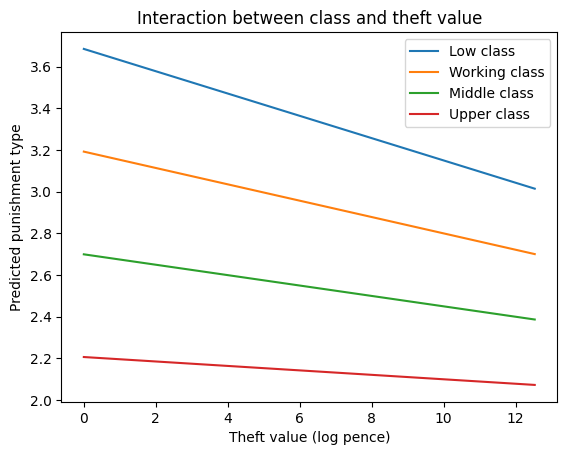

In [122]:
import matplotlib.pyplot as plt

for cls, label in zip([1, 2, 3, 4], ['Low class', 'Working class', 'Middle class', 'Upper class']):
    subset = pred_df[pred_df['occupation_code'] == cls]
    plt.plot(
        subset['log_value'],
        subset['predicted_punishment'],
        label=label
    )

plt.xlabel('Theft value (log pence)')
plt.ylabel('Predicted punishment type')
plt.title('Interaction between class and theft value')
plt.legend()
plt.show()


Here we can see very clearly that the higher class you are, the lower severity of punishment you are predicted to receive, but that otherwise the effect of the value of the theft is the same accross the board - highest penalties for lower value thefts and more leniency for higher value ones. 

Thinking about this within a historical contextualisation it may be interpretsble that higher value thefts are more likely to be repayable through fines (rated low [2] on the punishment scale) as they are likely to have result in financial gain, wheras low value thefts (food, clothes etc) are unlikely to be returnable, and more likely to be repeated (due to poverty or neccessity) and so somewhat illogically better punished harshly as a stronger deterent (a spinster who has stolen a bottle of gin won't keep stealing bottles of gin if she's dead). 

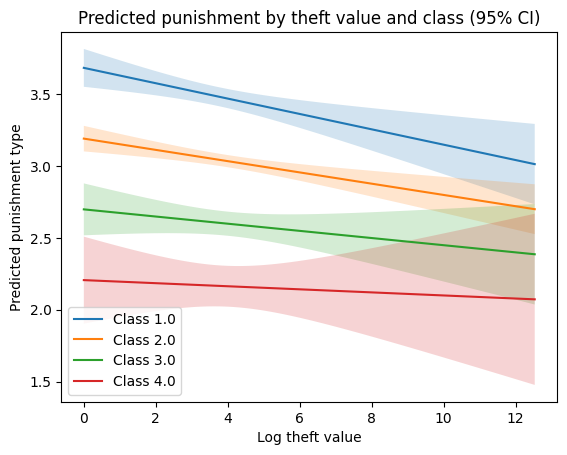

In [118]:
log_vals = np.linspace(
    theft_df['log_value'].min(),
    theft_df['log_value'].max(),
    200
)

classes = sorted(theft_df['occupation_code'].dropna().unique())

plt.figure()

for class_ in classes:
    pred_df = pd.DataFrame({
        'log_value': log_vals,
        'occupation_code': class_
    })

    # ci's
    pred = model.get_prediction(pred_df).summary_frame(alpha=0.05)

    # mean
    plt.plot(log_vals, pred['mean'], label=f'Class {class_}')

    plt.fill_between(
        log_vals,
        pred['mean_ci_lower'],
        pred['mean_ci_upper'],
        alpha=0.2
    )

plt.xlabel('Log theft value')
plt.ylabel('Predicted punishment type')
plt.title('Predicted punishment by theft value and class (95% CI)')
plt.legend()
plt.show()


This is just the same graph but with the inclusion of 95% confidence intervals - to demonstarte how broad the variation is that is represented by the lines. For each of these we can see that there is less variation in lower value theft punishments but much higher variation in high value. There is also much less variation across low class and much higer variation as you get to upper class - this might be partially caused by the higher numbers of low class data points providing better averages and predicitons, and the low quantities of high class data points resulting in much greater variability. 

In [119]:
for cls, label in zip([1, 2, 3, 4], ['Low', 'Working', 'Middle', 'Upper']):
    sub = theft_df[theft_df['occupation_code'] == cls]
    m = smf.ols('punishment_code ~ log_value', data=sub).fit()
    print(f"\n{label} class")
    print(m.params)



Low class
Intercept    3.683249
log_value   -0.028971
dtype: float64

Working class
Intercept    3.166975
log_value   -0.057372
dtype: float64

Middle class
Intercept    2.746577
log_value    0.005815
dtype: float64

Upper class
Intercept    0.128688
log_value    0.705826
dtype: float64


And finally I just wanted to run one final check to verify the findings - we can see by the intercepts that punishment severity is highly effected by class but that theft values effect is more variable - it has a small negative relationship with punishment for low and middle classes but almost no effect on the middle classes and a questionable impact for the upper classes - likely impacted by the low number of data points. 

### Hypothesis 3: Gender, Occupation, and Punishment Prediction - SK

>**Null Hypothesis (H₀):** Defendant gender and occupation cannot predict punishment type. These variables have no relationship with the punishment received.

>**Alternative Hypothesis (H₁):** Defendant gender and occupation significantly predict punishment type, with certain occupations and female gender associated with more lenient punishments.


Common Law. Starting from the Magna Carta to its form in the modern day, it is the system in which past court decisions shape how laws are interpreted and applied over time, and is known for its flexibility and continuity. And that is an important word. Continuity.

With the Old Bailey dataset, we can see this continuity play out in our CSV over 300 years worth of data. Britain is the birthplace of the Common Law, and exported it through influence and imperialism, and is arguably one of the countries most enduring and important global legacies. But with such a flexible system open to interpretation, how the law is applied under the grounds of Common Law can be controversial. The verdict of individual judges and juries can hold create influence, and thus their biases can hold greater weight, especially when first establishing precedence.

And it is that bias we want to look at, the hypothesis we want to test. Does a defendant's gender or occupation affect the punishment they may receive at the Old Bailey court? Furthermore, does this change with time? As such, we can form the following Null and Alternative Hypothesis:

>**Null Hypothesis (H₀):** Defendant gender, occupation, and year of trial have no effect on punishment severity (all coefficients = 0).

>**Alternative Hypothesis (H₁):** At least one of defendant gender, occupation, or year of trial significantly predicts punishment severity (at least one coefficient ≠ 0).

#### Cleaning

The first thing we're going to need to do is clean the data. For example, one issue we have is that the imprisonment length is non-numeric currently, as it was pulled via a regex function, so is currently in the form of strings. For example, "2 years". Another issue we have is that not every row has occupation as a viable piece of data. Only 20,000 rows have them. Which is, of course, still a lot of data. So, we are going to have to filter rows that have a punishment AND an associated occupation of the defendant.

This is only one such example of the cleaning we need to do. We shall go through it all as we go along.

In [1]:
import pandas as pd
import numpy as np

hypothesis3_df = pd.read_csv("old_bailey_actual_final.csv")

# Let us first perform a filtering on the rows that actually have an occupation
hypothesis3_df_culled = hypothesis3_df[hypothesis3_df['punishment'].notna() & hypothesis3_df['defendant_occupation'].notna()]

# Now, we need to drop rows that don't have a determined gender (by historical Britain's standards mind you)
hypothesis3_df_culled = hypothesis3_df_culled[hypothesis3_df_culled['defendant_gender'].isin(['male', 'female'])]

# Now, we just need to make sure all our strings for occupation are nice and similar so they can be compared
hypothesis3_df_culled['defendant_occupation'] = hypothesis3_df_culled['defendant_occupation'].str.lower().str.strip()

# Now, we are going to group the rarer occupations
# The main reason is because if we want to perform ordinal regression, we need enough cases per instance
# If the rarer occupations are separate, some of the coefficients will just be awful
american_psycho_ahhh_comparison = hypothesis3_df_culled['defendant_occupation'].value_counts().nlargest(10).index
hypothesis3_df_culled['occupation_grouped'] = hypothesis3_df_culled['defendant_occupation'].apply(lambda x: x if x in american_psycho_ahhh_comparison else 'other')

# Now, onto something a bit more interesting.

C:\Users\shayb\AppData\Local\Temp\ipykernel_14128\835674627.py:4: DtypeWarning: Columns (6,15,26) have mixed types. Specify dtype option on import or set low_memory=False.
  hypothesis3_df = pd.read_csv("old_bailey_actual_final.csv")


To even perform ordinal regression on this data, we are going to have to rank punishment on a scale. This is because, in ordinal regression, the outcome variable must have a natural order (i.e. typically numeric). So, we need to decide which punishments are "less severe" or "more severe".

In [2]:
my_punishment_beats_your_punishment = {
    'noPunish': 0, # Obviously, not being punished is the lowest ranking of punishment

    'miscPunish': 1, # These are usually your odd punishments that don't fit a category (because they aren't used enough). But it can include fines, for example. Actually, we might do an internal ranking for that.

    'corporal': 2, # Obviously, being beaten and whipped is pretty awful (and worse than a fine. The only comparable one is branding, which is included in miscPunish but can obviously vary in scale)

    'imprison': 3, # Being taken out of society is obviously the next step

    'transport': 4, # Being completely removed from society is the next step above, which was often considered worse than imprisonment given it was complete exile.
    # That said, some might take exile from Britain as a reward lol

    'death': 5 # Don't think I need to explain this one
}

#  Then, let's add it
hypothesis3_df_culled["punishment_severity"] = (
    hypothesis3_df_culled["punishment"]
    .map(my_punishment_beats_your_punishment)
)

Ahhh, but now we have another issue. Being fined 5 pounds and 500 pounds are completely different in their intent as a punishment. Furthermore, a 1 month prison sentencing is completely different to one for 20 years. As such, we need to establish a sub-ordination within miscPunish and imprison.

In [3]:
# Let's start with an internal scaling for imprisonment. 
# First, we shall need to clean the column, as they are currently in the form of strings and just awful in general

# Convert to lowercase and strip the whitespace
hypothesis3_df['imprisonment_length'] = hypothesis3_df['imprisonment_length'].str.lower().str.strip()

# Now, we need to create a function that will parse through all the options, in order to standardise them for numeric conversion
def i_hate_historical_record_keeping(x):
    if pd.isna(x):
        return np.nan
    x = str(x).lower().strip()
    
    # The code below will help us split the numeric value and the unit
    # i.e. days, months, weeks, years
    try:
        parts = x.split()
        number = int(parts[0])
        unit = parts[1]
        
        if 'day' in unit:
            return number / 30  # This is a simple approximation
        elif 'week' in unit:
            return number * 7 / 30  # As a result, so is this
        elif 'month' in unit:
            return number
        elif 'year' in unit:
            return number * 12
        else:
            return np.nan
    except:
        return np.nan
    

# Now, let's apply that function to the dataframe.
hypothesis3_df_culled['imprison_months'] = hypothesis3_df_culled['imprisonment_length'].apply(i_hate_historical_record_keeping)


# And lastly, we can group it all into severity levels of the ordinal variety ! ! ! :speak:
def imprisonment_severity(months):
    if pd.isna(months):
        return np.nan
    elif months <= 6: # 6 months
        return 0
    elif months <= 24: # 2 years
        return 1
    elif months <= 60: # 5 years
        return 2
    elif months <= 120: # 10 years
        return 3
    elif months < 240: # 20 years
        return 4
    else:
        return 5


# And voila!
hypothesis3_df_culled['imprison_severity'] = hypothesis3_df_culled['imprison_months'].apply(imprisonment_severity)

Now, we need to do the same but for fines! Luckily, these are already in the form of integers (the guy who did the XML extraction was real helpful with that huh). All we need to do is account for the different unit stuff. 

Now, marks only have an approximate unit conversion, by the way, but we'll do our best! It goes:

- 1 pound = 20 shillings

- 1 shilling = 12 pence

- 1 pound = 240 pence

- 1 guinea = 21 shillings = 252 pence

- 1 mark = 13.3333 shillings = 160 pence (really approximately on this one)


One thing to note, we do not need to adjust for inflation (at least, we can get away with not doing so). See, we are using fines as a sub-rank for punishment severity, not as a temporal economic measure to be scaled. As such, all the fines are relative to the time they are set, and thus the ordinal scale is retained without having to worry about inflation too much.

In [4]:
def how_many_pennies_innit(row):
    pounds = row.get('fine_value_pounds', 0) or 0
    shillings = row.get('fine_value_shillings', 0) or 0
    pence = row.get('fine_value_pence', 0) or 0
    guineas = row.get('fine_value_guineas', 0) or 0
    marks = row.get('fine_value_marks', 0) or 0
    
    total = (
        pounds*240 + 
        shillings*12 + 
        pence + 
        guineas*252 + 
        marks*160
    )
    return total

hypothesis3_df_culled['fine_total_pence'] = hypothesis3_df_culled.apply(how_many_pennies_innit, axis=1)

# Now, let's put these into ordinal bins, similarly to how we did before.

def send_500_pennies_to_israel(pence):
    if pd.isna(pence) or pence == 0:
        return 0  # If no fine
    
    elif pence <= 50*12:       # ≤50 shillings, or around £2.5
        return 1
    elif pence <= 200*12:      # 50–200 shillings, or around £10
        return 2
    elif pence <= 1000*12:     # 200s–1000 shillings, or around £50
        return 3
    else:                      # More than ONE THOUSAND shillings 
        return 4

hypothesis3_df_culled['fine_severity'] = hypothesis3_df_culled['fine_total_pence'].apply(send_500_pennies_to_israel)


Now, we need to bring the sub-ordinal rankings into our general ranking, and we should be all good to proceed!


NOTE: We did not end up using the sub-ordinal scales, as we'd have to make a bunch more assumptions. Think about it, if we were to add these values to the punishment severity ones, we'd be asking ourselves the following questions:
- Is 6 months imprisonment “equivalent” to corporal punishment?
- Is a £10 fine closer to 3 months prison or 12?
- Is death infinitely worse or just “one step higher”?

Given we are attempting Ordinal Regression, those questions are just completely and utterly unviable. As such, we'll have to give them a pass.

But oh well, it was interesting to code at the very least!

In [5]:
hypothesis3_df_culled['punishment_sub_rank'] = 0
hypothesis3_df_culled.loc[hypothesis3_df_culled['punishment'] == 'imprison', 'punishment_sub_rank'] = \
    hypothesis3_df_culled['imprison_severity']
hypothesis3_df_culled.loc[hypothesis3_df_culled['punishment'] == 'miscPunish', 'punishment_sub_rank'] = \
    hypothesis3_df_culled['fine_severity']

Let's take a look at it.

In [6]:
hypothesis3_df_culled

,session_date,session_year,trial_id,defendant_name,defendant_gender,defendant_age,defendant_occupation,victim_gender,offence_category,offence_subcategory,...,fine_value_marks,juror_ids,judge_ids,occupation_grouped,punishment_severity,imprison_months,imprison_severity,fine_total_pence,fine_severity,punishment_sub_rank
20,16740909,1674,t16740909-1,John Randal,male,NaN,butler,male,theft,theftFromPlace,...,0,NaN,NaN,other,5,NaN,NaN,0,0,0.0
21,16740909,1674,t16740909-1,John Randal,male,NaN,butler,male,kill,murder,...,0,NaN,NaN,other,5,NaN,NaN,0,0,0.0
30,16741014,1674,t16741014-1,the Boy,male,NaN,boy,NaN,theft,animalTheft,...,0,NaN,NaN,boy,5,NaN,NaN,0,0,0.0
41,16741212,1674,t16741212-1,William Burnet,male,NaN,romish priest,NaN,royalOffences,religiousOffences,...,0,NaN,NaN,other,5,NaN,NaN,0,0,0.0
42,16741212,1674,t16741212-1,William Burnet,male,NaN,romish priest,NaN,royalOffences,religiousOffences,...,0,NaN,NaN,other,5,NaN,NaN,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133104,18341016,1834,t18341016-144,MARY TACONET,female,36,charwoman,male,theft,simpleLarceny,...,0,f18341016-1-person18; f18341016-1-person19; f1...,f18341016-1-person4; f18341016-1-person5; f183...,other,3,0.233333,0.0,0,0,0.0
133122,18341016,1834,t18341016-160,GEORGE WOMERSLEY,male,39,salesman,male,theft,stealingFromMaster,...,0,f18341016-1-person18; f18341016-1-person19; f1...,f18341016-1-person4; f18341016-1-person5; f183...,other,3,3.000000,0.0,0,0,0.0
133123,18341016,1834,t18341016-161,MARK BREALEY,male,39,apprentice,male,theft,stealingFromMaster,...,0,f18341016-1-person18; f18341016-1-person19; f1...,f18341016-1-person4; f18341016-1-person5; f183...,apprentice,4,NaN,NaN,0,0,0.0
133132,18341016,1834,t18341016-168,GEORGE DUKE,male,15,pot-boy,male,theft,simpleLarceny,...,0,f18341016-1-person18; f18341016-1-person19; f1...,f18341016-1-person4; f18341016-1-person5; f183...,other,4,NaN,NaN,0,0,0.0


In [7]:
!pip install scipy 
!pip install matplotlib
!pip install seaborn
!pip install statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, chi2
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [8]:
# Let's preset our seaborn style plots and in general, make some design choices. 
# The visual story we're trying to tell is important here
# Apparently...

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11

#### So, what patterns can we find in punishment based on our hypothesis parameters?

Before we get into ordinal modelling (and best we do take a short breath, because it is HORRIBLE), let's first just take a look at the data and actually see the business. What can we visually see in the data before we start approving or disproving the Null hypothesis? 

Well, let's make some figures and find out.

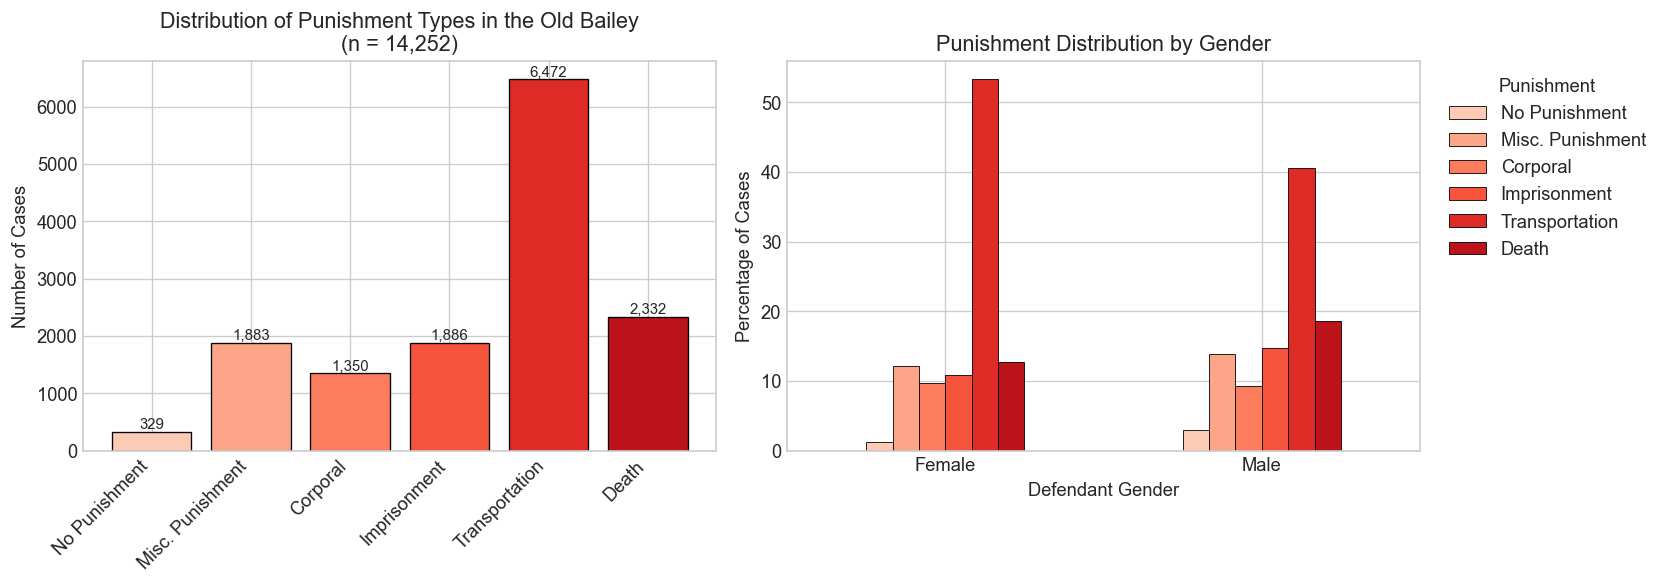

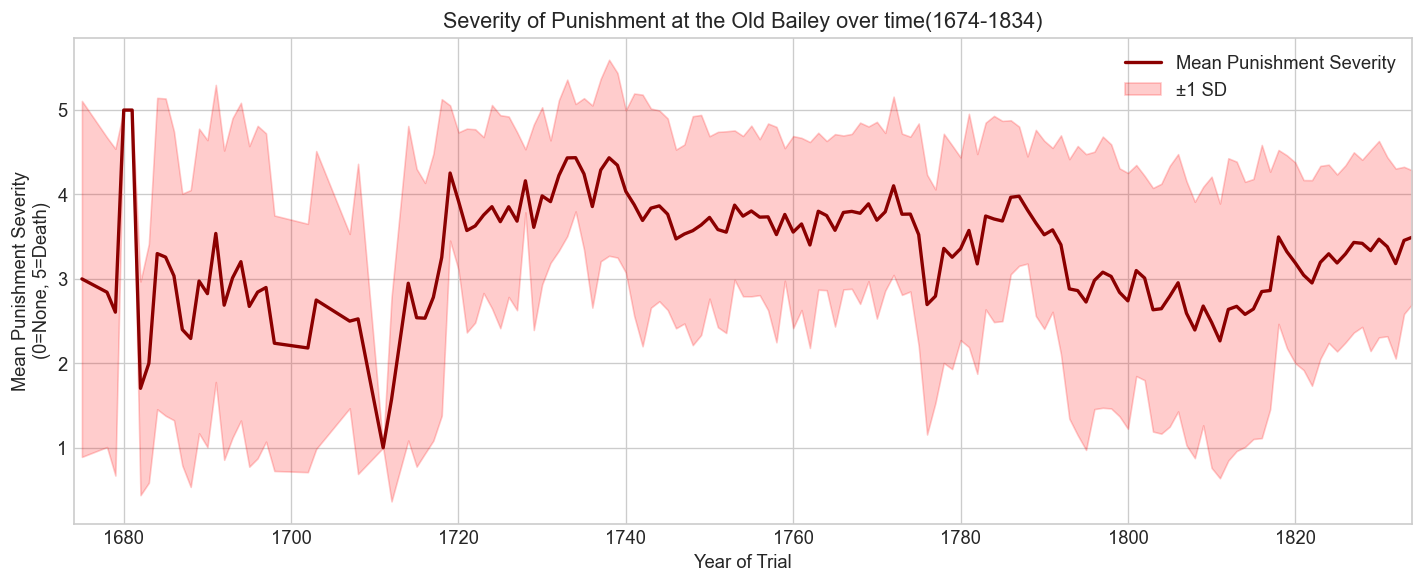

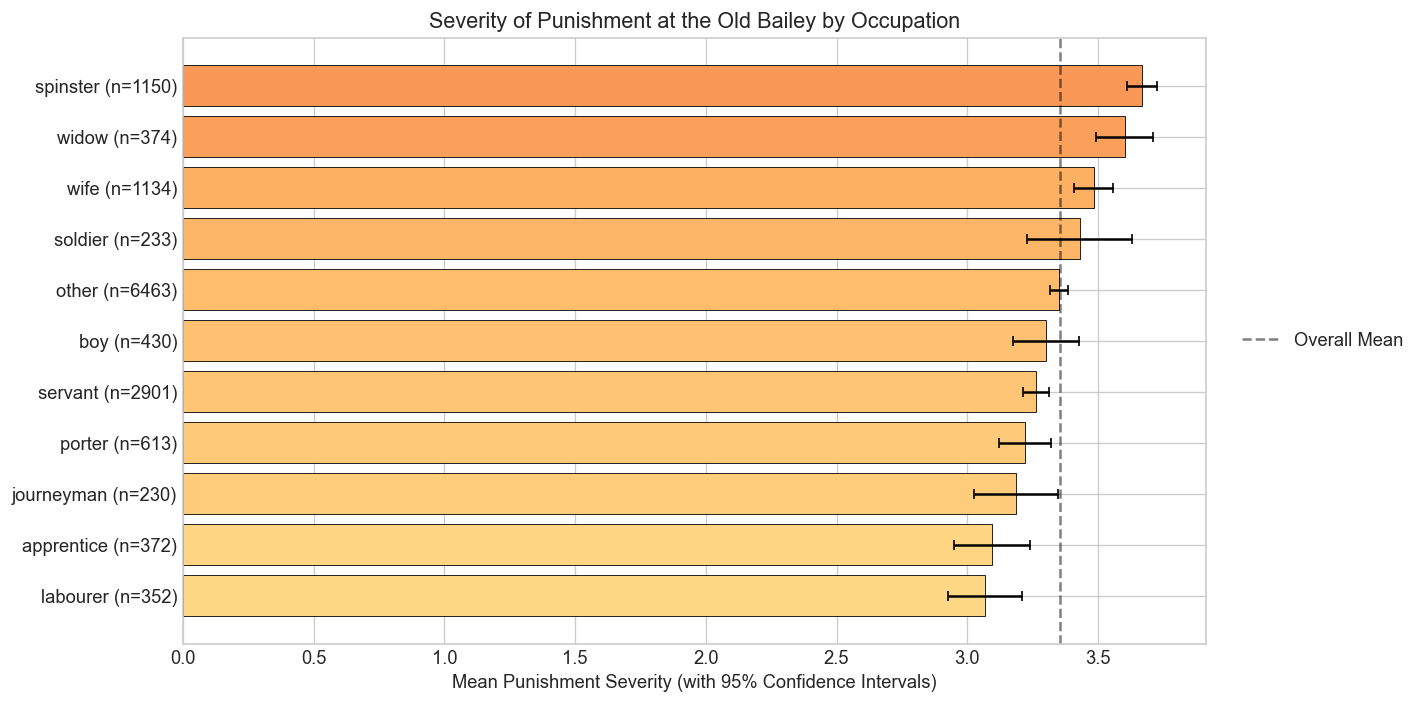

In [9]:
# Right, the first thing we're going to do is see how punishment is distributed, both internally (count comaparison) and externally (against gender)
# Let's make this a single figure for simplicity sake. 
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


# First, we need to make a plot for the overall distribution of punishments. 
da_punishment_order = ['noPunish', 'miscPunish', 'corporal', 'imprison', 'transport', 'death'] # Here are the categories we defined before
i_will_not_be_labelled = ['No Punishment', 'Misc. Punishment', 'Corporal', 'Imprisonment', 'Transportation', 'Death'] # Nice labels to go with that

counts = hypothesis3_df_culled['punishment'].value_counts().reindex(da_punishment_order) # This counts our punishment types 
colours = plt.cm.Reds(np.linspace(0.2, 0.8, 6)) # This makes the colour scheme all red, just progressively darker shades
# I thought it was apt personally
# Also, being forced to say 'color' is going to be the death of me


# This is our plot on the left hand side. It's our distribution of punishment types and will give us an understanding of just how the time period we've got operated.
bars = axes[0].bar(range(6), counts.values, color=colours, edgecolor='black', linewidth=0.8)
axes[0].set_xticks(range(6))
axes[0].set_xticklabels(i_will_not_be_labelled , rotation=45, ha='right')
axes[0].set_ylabel('Number of Cases')
axes[0].set_title('Distribution of Punishment Types in the Old Bailey\n(n = {:,})'.format(len(hypothesis3_df_culled)))

# Make sure to add count labels to your bars. Quick PSA but it makes it unreadable
# I might have done dat 
for bar, count in zip(bars, counts.values):
    axes[0].annotate(f'{count:,}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                     ha='center', va='bottom', fontsize=9)


# For it's accompanying plot, let's took a look at punishment by gender.
# Again, there's no modelling or statistical testing here.
# We just want to see how it is raw and observable
battle_of_the_sexes = pd.crosstab(hypothesis3_df_culled['defendant_gender'], hypothesis3_df_culled['punishment'], normalize='index') * 100
battle_of_the_sexes = battle_of_the_sexes.reindex(columns=da_punishment_order) # Let's put it in the colour-coded punishment order

# And then we plot
battle_of_the_sexes.plot(kind='bar', ax=axes[1], color=colours, edgecolor='black', linewidth=0.5)
axes[1].set_xlabel('Defendant Gender')
axes[1].set_ylabel('Percentage of Cases')
axes[1].set_title('Punishment Distribution by Gender')
axes[1].legend(title='Punishment', labels=i_will_not_be_labelled, bbox_to_anchor=(1.02, 1), loc='upper left')
axes[1].set_xticklabels(['Female', 'Male'], rotation=0)

plt.tight_layout()
plt.show()





# Right, now let's plot the sevarity of the punishment over time. 
fig, ax = plt.subplots(figsize=(12, 5))

# The first thing we need to do is calculate the yearly severity of punishments by taking the year
oh_god_how_severe_is_it= hypothesis3_df_culled.groupby('session_year')['punishment_severity'].agg(['mean', 'std', 'count'])
oh_god_how_severe_is_it= oh_god_how_severe_is_it[oh_god_how_severe_is_it['count'] >= 10] # This line was a problem I had with the last coding project I did
# At some point, you just have to let bygones be bygones and let some data go. 
# We don't want to extrapolate or overcomplicate, nor do we want to allow outliers to make serious headway in our analysis
# As such, let's just admit we don't have the data where we don't have it
# Good data practice kiddos

# This time, we'll add a standard deviation uncertainty bad
# Not only because it looks cool but it will also tell us how confident we are in making any simple observations
ax.plot(oh_god_how_severe_is_it.index, oh_god_how_severe_is_it['mean'], color='darkred', linewidth=2, label='Mean Punishment Severity')
ax.fill_between(oh_god_how_severe_is_it.index, 
                oh_god_how_severe_is_it['mean'] - oh_god_how_severe_is_it['std'],
                oh_god_how_severe_is_it['mean'] + oh_god_how_severe_is_it['std'],
                alpha=0.2, color='red', label='±1 SD')

ax.set_xlabel('Year of Trial')
ax.set_ylabel('Mean Punishment Severity\n(0=None, 5=Death)')
ax.set_title('Severity of Punishment at the Old Bailey over time(1674-1834)') # These are the years our filtered dataset cover
ax.legend()
ax.set_xlim(hypothesis3_df_culled['session_year'].min(), hypothesis3_df_culled['session_year'].max())

plt.tight_layout()
plt.show()






# Lastly, lets observe how punishment changes with occupation, another one of our questions
fig, ax = plt.subplots(figsize=(12, 6))

# First, let's calculate the mean severity by occupation 
# This is similar to how we did so for gender, but changing to occupation 
punish_the_canned_food_makers = hypothesis3_df_culled.groupby('occupation_grouped')['punishment_severity'].agg(['mean', 'std', 'count'])
punish_the_canned_food_makers = punish_the_canned_food_makers.sort_values('mean', ascending=True)

y_position = np.arange(len(punish_the_canned_food_makers))
occupation_colours = plt.cm.RdYlGn_r(punish_the_canned_food_makers['mean'] / 5)  # Color by severity

# Let's get some confidence intervals so its not completely pathetic
bars = ax.barh(y_position, punish_the_canned_food_makers['mean'], xerr=punish_the_canned_food_makers['std']/np.sqrt(punish_the_canned_food_makers['count'])*1.96,
               color=occupation_colours, edgecolor='black', linewidth=0.5, capsize=3)
ax.set_yticks(y_position)
ax.set_yticklabels([f"{occ} (n={int(punish_the_canned_food_makers.loc[occ, 'count'])})" for occ in punish_the_canned_food_makers.index])
ax.set_xlabel('Mean Punishment Severity (with 95% Confidence Intervals)')
ax.set_title('Severity of Punishment at the Old Bailey by Occupation')
ax.axvline(x=hypothesis3_df_culled['punishment_severity'].mean(), color='black', linestyle='--', alpha=0.5, label='Overall Mean')
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

plt.tight_layout()
plt.show()

So, what does any of this actually tell us.

- Let's start with our first figure. On the left we can see that transportation is the most common punishment, roughly 45%. And historically, this makes sense. You need to think about Britain, especially in the late 1700s and onwards, as a nation expanding and growing. And running out of space. The Industrial Revolution, a phenomena exclusive to Britain for many years, exploded the British population and economy. With a greater population, you have more people committing crimes. Which means the prisons are more full. So on, so forth. This started as the Thirteen Colonies in America, but shifted to Australia after the American Revolution. Typically, it was seen as a more humane alternative to a society that was beginning to frown on executions, come the advent of liberalism being exported from the likes of John Locke.

  - That said, death was still common, a bygone product of the Medieval era. But interestingly, no Punishment was the rarest. I am curious as to the reasons. It's likely because courts back then were pre-filtered, i.e., had a selection bias. By the time a case reached a jury, it was already "pre-selected" for guilt. 
  
   - For our gender comparison, we can see that women received more transportation charges. Potentially due to them being on the better end of humane treatment regarding death, with executing women potentially seen as barbaric and uncouth. Men have a notably higher death and imprisonment rate.

- Our second figure, punishment over time, shows us that there is massive volatility in the early period, with a huge SD band and erratic mean pointing to small sample sizes or perhaps genuine instability in sentencing. We then reach a peak severity in the early-mid -> mid 1700s, where the mean of 4.0/4.5 indicates that transportation/death were dominant as punishment. The drop seen after this could potentially be due to transportation no longer being a viable option, given the American revolution. Otherwise, this is likely due to a Enlightenment-era penal reform with the reduced use of capital punishment. 

  - There is also a dip around 1710-1720. But it could likely be due to data disparity.

- Finally, Figure 3. Labourers and apprentices received the least severe punishment on average, while spinsters, widows, and wives received the most severe punishments. All the roles of women, how curious. Perhaps though, this is due to their limited role in society, and thus those are the main occupations available to them; while those of men would be more spread over many occupations.

  - See, at face value, we would think women were less severe, as per Figure 1. But this is the raw mean severity by occupation, not controlling for gender at all. Again, what you're seeing is female occupations being driven up by transportation that we gave a severity of 4.

  - Transportation scores higher on your severity scale than imprisonment, even though contemporaries might have debated which was actually worse. This raises an interesting question about our ranking system. Because it is very debateable. Being shipped to Australia for 7 years vs. 6 months in Newgate. Which would you pick? 



Regardless, our visualisations show there are interesting relationships to be found under a greater statistical lens, so let's get underway!



*Quick side, I opted not to perform chi-square tests prior to the regression analysis. Chi-square would only tell us whether gender and punishment are associated in isolation, something our descriptive visualisations already make somewhat obvious? Besides, ordinal logistic regression answers the same question but simultaneously controls for occupation and year, estimates effect sizes, and provides confidence intervals. Running chi-square first would be redundant; the regression subsumes it. And if there's one thing I like doing...*

###### *It's less work :P*

#### Onto Ordinal Regression

So, why Ordinal Regression? Well, punishment as a concept is ordered (some punishments are worse than others) and if we want to say "x person received a worse punishment", then we need to consider the data to be ordinal. This is what OLR (Ordinal Logistic Regression) is desgined for, it allows us to model how our factors like gender and occupation affect the likelihood of receiving a worse punishment on the ordinal scale. And, we don't have to assume each punishment has an equal distance between them (which they don't and I cannot imagine even trying to figure that out). Note that putting the punishment types on a scale of 0-5 does not assume magnitude, what Ordinal Regression does is that it estimates thresholds between categories.

There is no "per unit" punishment. Instead, we are asking ourselves what affects the odds that a case crosses from one punishment category to a higher one? Now, when doing most modelling, you make a Null model. This is a model where you only use the intercept and no predictors, and then you can compare your model to it to see if doing a model is even worth it. 

The thing is, OLR does not use a single intercept. As we explained, it uses a variety of thresholds that replace the intercept. So, if we tried to make a Null model, it would consist of only the thresholds between the categories. Which is awfully difficult to make coding software agree to make. Attempts to get around this issue failed, so we moved on from doing a comparison to a Null model in this particular case. 

But before we continue, let's talk about...

<h5 style="text-align:center;">Assumptions!</h5>

*Assumption 1*

The first assumption of Ordinal Regression we need to tackle is a simple one of sample size.

Ordinal logistic regression, like all maximum likelihood estimation methods, requires sufficient observations in each cell of the predictor matrix. A good rule of thumb is having at least 10 cases per combination of predictor level and outcome category. When category cells are sparse, the model struggles to estimate stable coefficients. This makes the errors inflate, and our confidence intervals become unreliable (or unconfident if you will), and in extreme cases the model fails to converge entirely.

Let's get to it!

In [10]:
# Right, let's get coding to check this first assumption

# First, we'll check the sample size for gender
punish_the_genders = pd.crosstab(hypothesis3_df_culled['defendant_gender'],
                         hypothesis3_df_culled['punishment']) # We create a contingency table here showing how many cases fall into a gender x punishment combination
is_it_a_small_gender = int((punish_the_genders < 10).sum().sum()) # And here we will check how many of each variation there are under the lucky statistical ten


# Now, we shall create some readable prints to clearly present the results
print("\nGender × Punishment:")
print(f"  Total cells: {punish_the_genders.size}")
print(f"  Cells with n < 10: {is_it_a_small_gender}")

if is_it_a_small_gender == 0:
    print("  There are no sparse cells. You may keep on assuming for gender (or don't, it's 2025)")
else:
    print("  Sparse Cells detected! Give up on the project NOW")


# Now, let's do the same for punishment

now_punish_the_occupations = pd.crosstab(hypothesis3_df_culled['occupation_grouped'],
                      hypothesis3_df_culled['punishment'])
a_very_small_job = int((now_punish_the_occupations < 10).sum().sum())

print("\nOccupation × Punishment:")
print(f"  Total cells: {now_punish_the_occupations}")
print(f"  Cells with n < 10: {a_very_small_job}")


# Now, I am being a bit more rigorous for occupation, as it has a lot more variation
if a_very_small_job == 0:
    print("  No sparse cells yippee! Everyone has the same job in London and the assumption holds!")
elif a_very_small_job <= 10:
    print("  WARNING. SOME SPARSE CELLS DETECTED")
    print("      Not to worry! These occur in rare punishment categories and do not invalidate the model.") # To be frank for a moment
    # We know this with  inspection of the occupation × punishment contingency table.
    # All the sparse cells are concentrated in the 'noPunish' punishment category.
    # This is rare overall anyway, and the sparse rather than being spread across occupations or outcomes.
    # You can run the dataframe yourself in the next code block if you want 
    # They won't break the model and they won't contribute much to it either
else:
    print("  TOO MANY SPARSE CELLS. DELETE THIS NOTEBOOK, NOW!")

# As a final verdict:
print("\nFINAL VERDICT:")
if is_it_a_small_gender == 0 and a_very_small_job <= 10:
    print("The sample size assumption is GOOD ENOUGH for ordinal logistic regression.")
else:
    print("Sample size assumption not met at all - do not bother brah")


Gender × Punishment:
  Total cells: 12
  Cells with n < 10: 0
  There are no sparse cells. You may keep on assuming for gender (or don't, it's 2025)

Occupation × Punishment:
  Total cells: punishment          corporal  death  imprison  miscPunish  noPunish  transport
occupation_grouped                                                            
apprentice                44     43        50          62        14        159
boy                       69     47        30          33        20        231
journeyman                23     16        40          35         3        113
labourer                  60     50        59          61         4        118
other                    523   1279       976         909       184       2592
porter                    54     45       106          79        18        311
servant                  269    433       444         434        71       1250
soldier                    7     77        29          53         2         65
spinster           

The sample size assumption is met. Yippee!

Gender × punishment contains 12 cells with zero sparsity. Occupation × punishment contains 66 cells, of which 7 fall below the n < 10 threshold. These sparse cells cluster in the "noPunish" category. This is a rare outcome comprising only 2.3% of our data, so we can give it somewhat of a steady pass (just make sure to note it for later). As such, on the front of this assumption, I will say the model can estimate reliable coefficients for the punishment categories that actually matter.

Assumption 2*

The proportional odds assumption is the big one, and annoyingly, it is the hardest one to code.

It is the assumption that makes ordinal regression ordinal rather than just a stack of separate binary logistic regressions in a funny trenchcoat. It states that the effect of each predictor is consistent across all threshold cutpoints. If being male increases your odds of receiving transportation vs imprisonment by a factor of 2, it should also increase your odds of receiving death vs transportation by roughly the same factor.

When this assumption holds, we can summarise gender's effect with a single coefficient. When it doesn't, that coefficient becomes a weighted average of varying effects. This obviously is still informative, very much so, but it potentially masks important heterogeneity. Violating this doesn't necessarily invalidate the model, but it does mean our single coefficient is smoothing over a more complex reality, something that will muddy our conclusion.

In [11]:
# Right, onto le assumption 2. The Proportional Odds Assumption.
# God help me, this is going to be a slog to code.

# First, let's grab our outcome column
# This is a safety check in case column names differ between extractions
outcome_col = "punishment_severity" if "punishment_severity" in hypothesis3_df_culled.columns else "punishment_sub_rank"
if outcome_col not in hypothesis3_df_culled.columns:
    raise KeyError("We NEED an ordinal outcome column, CAESAR!")


# Now we build a clean dataframe for this assumption test
# Same logic as before, if there's NaNs, we execute them :) 
# Now, we enter the assumption arena
the_assumption_arena = hypothesis3_df_culled[["defendant_gender", "occupation_grouped", "session_year", outcome_col]].copy()
the_assumption_arena["session_year"] = pd.to_numeric(the_assumption_arena["session_year"], errors="coerce")
the_assumption_arena[outcome_col] = pd.to_numeric(the_assumption_arena[outcome_col], errors="coerce")
the_assumption_arena = the_assumption_arena.dropna()


# Time to set up our predictors
# Same dummy variable treatment as the main model, where gender and occupation become 0s and 1s
# Year gets centred so the intercept isn't some bizarre value from 1750 (goated year as years go tbh)
# Opening of Westminster Bridge ! ! !! ! ! !! 
# Now we MUST code in the name of the Brant test (the test that checks for proportional odds assumption)
# I curse his name
X_for_brant = pd.get_dummies(the_assumption_arena[["defendant_gender", "occupation_grouped"]], drop_first=True).astype(float)
X_for_brant["session_year_centred"] = the_assumption_arena["session_year"] - the_assumption_arena["session_year"].mean()
X_for_brant = sm.add_constant(X_for_brant, has_constant="add")
y_for_brant = the_assumption_arena[outcome_col].astype(float)



# Now we need to decide where to "cut" (like a samurai) our ordinal outcome into binary comparisons
# If we've got our nice 0-5 severity scale, we use those natural cutpoints
# Otherwise we fall back to quantiles and pray to Jesus and Allah
unique_severities = np.sort(y_for_brant.unique())

if len(unique_severities) <= 10 and y_for_brant.min() <= 0 and y_for_brant.max() <= 5:
    # We have our  severity scale coming in clutch here
    cutpoints = [1, 2, 3, 4, 5]
    cut_names = [f"Severity ≥ {c}" for c in cutpoints]
    print("Using the 0-5 punishment severity scale for cutpoints. Super duper.")
else:
    # Quantile fallback - less elegant in a more civilised age
    cutpoints = np.unique(np.quantile(y_for_brant, [0.2, 0.4, 0.6, 0.8]))
    cut_names = [f"Y ≥ {c:.3g}" for c in cutpoints]
    print("Using quantile-based cutpoints. Fml.")


# And now here is the bit I'm worried about.
# I write this before hand in prayer it works
# First, we fit a separate binary logistic regression at each threshold cutpoint
# Then we compare whether the coefficients stay roughly similar or change
# If defendant_gender_male is 0.5 at one cutpoint and 2.5 at another, we have a problem.
# And I mean, "give up on OLR problem"

the_variables_we_care_about_lol = [c for c in X_for_brant.columns if c.startswith("defendant_gender_")] + ["session_year_centred"]
the_coefficient_collection = {}

for cutpoint, cutpoint_name in zip(cutpoints, cut_names):
    # Create binary outcome: is the punishment at least this severe?
    binary_outcome = (y_for_brant >= cutpoint).astype(int)
    
    # We need enough cases on both sides of the cut to fit a sensible model
    # 50 is arbitrary but reasonable - below that and we're just fitting noise
    n_above = binary_outcome.sum()
    n_below = len(binary_outcome) - n_above
    
    if n_above < 50 or n_below < 50:
        print(f"  Skipping {cutpoint_name}: only {n_above} cases above, {n_below} below. Not enough to model reliably.")
        continue
    
    try:
        binary_logit = sm.Logit(binary_outcome, X_for_brant).fit(disp=0)
        for variable in the_variables_we_care_about_lol:
            if variable in binary_logit.params.index:
                the_coefficient_collection.setdefault(variable, {})[cutpoint_name] = float(binary_logit.params[variable])
    except Exception:
        # Sometimes logistic regression throws a tantrum due to separation or convergence issues
        # We just skip that cutpoint and move on with our lives
        # God bless America :speak:
        print(f"  Skipping {cutpoint_name}: model threw a fit (probably complete separation)")
        continue

# Time for the verdict
# PRAY
print("\n" + "="*70)
print("PROPORTIONAL ODDS ASSUMPTION CHECK")
print("="*70)

if not the_coefficient_collection:
    print("\nCould not evaluate the proportional odds assumption.")
    print("Reason: too few cases or complete separation at all thresholds.")
    print("This doesn't necessarily invalidate the model, but we can't formally check this assumption.")
    print("Travel with caution. This code is the home of the bones to many fallen HEROES")
else:
    brant_lite_results = pd.DataFrame(the_coefficient_collection).T

    print("\nCoefficients at each punishment threshold:")
    print("(If the assumption HOLDS, these should be roughly similar across columns)\n")
    print(brant_lite_results.round(3).to_string())
    
    print("\n" + "-"*70)
    print("COEFFICIENT STABILITY CHECK")
    print("-"*70)

    assumption_looking_good = True
    
    for variable in brant_lite_results.index:
        coef_range = brant_lite_results.loc[variable].max() - brant_lite_results.loc[variable].min()
        coef_mean = brant_lite_results.loc[variable].mean()
        
        # A range over 1.0 in log-odds is nothing to scoff at
        # The effect more than doubles/halves across thresholds
        if coef_range > 1.0:
            status = "CONCERNING"
            assumption_looking_good = False
        elif coef_range > 0.5:
            status = "ACCEPTABLE"
        else:
            status = "STABLE"
        
        print(f"  {variable}:")
        print(f"      Range: {coef_range:.3f} | Mean: {coef_mean:.3f} | Status: {status}")
    
    print("\n" + "="*70)
    print("FINAL VERDICT")
    print("="*70)
    
    if assumption_looking_good:
        print("\nThe proportional odds assumption is ACCEPTABLY MET. YIPPEE!")
        print("Predictor effects are reasonably consistent across punishment thresholds.")
        print("Our ordinal logistic regression isn't lying to us. Probably...")
    else:
        print("\nThe proportional odds assumption is QUESTIONABLE.")
        print("Some predictors show notably different effects at different thresholds.")
        print("This doesn't mean we throw out the model, but interpretation should be cautious.")
        print("Consider acknowledging this in your limitations section.")

Using the 0-5 punishment severity scale for cutpoints. Super duper.

PROPORTIONAL ODDS ASSUMPTION CHECK

Coefficients at each punishment threshold:
(If the assumption HOLDS, these should be roughly similar across columns)

                       Severity ≥ 1  Severity ≥ 2  Severity ≥ 3  Severity ≥ 4  Severity ≥ 5
defendant_gender_male        -0.387         0.046        -0.029         0.090         0.669
session_year_centred         -0.013         0.004         0.004        -0.008        -0.014

----------------------------------------------------------------------
COEFFICIENT STABILITY CHECK
----------------------------------------------------------------------
  defendant_gender_male:
      Range: 1.056 | Mean: 0.078 | Status: CONCERNING
  session_year_centred:
      Range: 0.018 | Mean: -0.005 | Status: STABLE

FINAL VERDICT

The proportional odds assumption is QUESTIONABLE.
Some predictors show notably different effects at different thresholds.
This doesn't mean we throw out the mod

Oh my god, it worked. Let's talk about it briefly.

The proportional odds assumption holds for year (coefficient range = 0.018, so it is stable across thresholds) but is violated for gender (coefficient range = 1.056). Closer inspection reveals the gender effect flips direction: male defendants were less likely to receive any punishment versus acquittal (β = -0.387) but more likely to receive death versus lesser punishments (β = 0.669). 

This suggests judicial treatment of gender was not uniform across our severity spectrum  (which could be a problem with the spectrum itself, my bad). In reality, the courts may have acquitted men more readily at the low end while sentencing them more harshly at the top. We retain the ordinal model but interpret the gender coefficient as an average effect that obscures this nonuniformity.


Anyway! Let's move onto actually making the model below!

In [12]:
# This is a piece of safety code
# It will automatically select a column name in the event a column name changes for whatever reason.
# Given how everyone may do their own extraction process of the XMLs, I wanted to account for any name changes
outcome_candidates = ["punishment_severity", "punishment_score", "punishment_sub_rank", "punishment_rank"]
outcome_col = next((c for c in outcome_candidates if c in hypothesis3_df_culled.columns), None)
if outcome_col is None:
    raise KeyError(f"None of these outcome columns exist: {outcome_candidates}")


# Now let's generate the dataframe for the purpose of OLR

# If there are any NaN's in our columns, we take them out back and shoot them
# Morbid but accurate, and an important check so our model doesn't cry in pain
the_code_bouncer = ["defendant_gender", "occupation_grouped", "session_year", outcome_col] # These are the only rows permitted for analysis. 
john_model= hypothesis3_df_culled.dropna(subset=the_code_bouncer).copy()

# Let's convert everything to numeric, just in case (we did this in cleaning but we aren't being too careful)
# Especially given the Old Bailey data extraction process has to be done individually should this code be replicated
# Thus for the sake of replicability, we need these safeguards
john_model["session_year"] = pd.to_numeric(john_model["session_year"], errors="coerce")
john_model[outcome_col] = pd.to_numeric(john_model[outcome_col], errors="coerce")
john_model = john_model.dropna(subset=["session_year", outcome_col])

# Remember that punishment severity scale we made? 
# Basically, we need to make sure it's nice and numeric too
john_model["y_cat"] = john_model[outcome_col].round().astype(int)

# And then we'll get a sorted list of our categories to wrap up
categories = sorted(john_model["y_cat"].unique())
df_model = john_model[john_model["y_cat"].isin(categories)].copy()




# Right, now onto the actual work.

# We need to convert our predictors (like gender and occupation) into numeric dummy variables
# Aka, turn our labels into zeros and ones so the model can compare them. Computers love this 0 and 1 stuff man.
# As well sort the time function and the categorical punishment scaling
X = pd.get_dummies(john_model[["defendant_gender", "occupation_grouped"]], drop_first=True)
john_model["session_year_centred"] = john_model["session_year"] - john_model["session_year"].mean()
X["session_year_centred"] = john_model["session_year_centred"]

# Once again, we force the predictor columns to be numeric floats so our model doesn't off itself
# You'll float too Georgie
# That was a Pennywise reference
# I think Pennywise would suck at coding respectfully...
X = X.astype(float)

# This tells our model that the outcome is a categorical variable, and not a continuous numeric scale
# Ala the difference between OLR and other regression types
y = pd.Categorical(john_model["y_cat"], ordered=True, categories=categories) # Make sure to specify the valid category order




# And now we build the model using the provided function
# Simple as
model = OrderedModel(y, X, distr="logit")
res = model.fit(method="bfgs", disp=0)

print("\n" + "="*80)
print("ORDINAL LOGIT RESULTS")
print("="*80)
print(res.summary())





# Now, I don't know about you but I hate those standard outputs
# I literally dropped more than 30% on that during a Process Piece lol
# So, we'll make a dataframe containing the results for us to use later if necessary

k = X.shape[1]  # This is our number of predictors
beta = res.params[:k] # This are the effects of the predictors, our k coefficients
se = res.bse[:k] # These are our standard errors for said coefficients
pvals = res.pvalues[:k] # Our p-values
ci = res.conf_int().iloc[:k] # Our confidence intervals

# The below code will convert from log odds to odd ratios
# Meaning its not some number of morbillion digits and is instead a ratio of odds
# Like a bookie, except with less (or perhaps more) stakes
or_ = np.exp(beta)
or_l = np.exp(ci[0])
or_u = np.exp(ci[1])

da_results = pd.DataFrame({
    "coef": beta,
    "se": se,
    "p": pvals,
    "OR": or_,
    "OR_2.5%": or_l,
    "OR_97.5%": or_u
}, index=X.columns).sort_values("p")

da_results



ORDINAL LOGIT RESULTS
                             OrderedModel Results                             
Dep. Variable:                      y   Log-Likelihood:                -21130.
Model:                   OrderedModel   AIC:                         4.229e+04
Method:            Maximum Likelihood   BIC:                         4.242e+04
Date:                Wed, 17 Dec 2025                                         
Time:                        22:14:08                                         
No. Observations:               14252                                         
Df Residuals:                   14235                                         
Df Model:                          12                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
defendant_gender_male             0.2320      0.043      5.342      0.

,coef,se,p,OR,OR_2.5%,OR_97.5%
session_year_centred,-0.007999,0.000432,1.494118e-76,0.992033,0.991193,0.992873
occupation_grouped_spinster,0.685944,0.114779,2.283764e-09,1.985646,1.585630,2.486577
defendant_gender_male,0.232036,0.043435,9.187149e-08,1.261165,1.158243,1.373233
occupation_grouped_wife,0.599523,0.116636,2.745526e-07,1.821251,1.449069,2.289024
occupation_grouped_widow,0.631741,0.137519,4.351726e-06,1.880882,1.436498,2.462738
occupation_grouped_other,0.445104,0.097417,4.899359e-06,1.560653,1.289391,1.888983
occupation_grouped_soldier,0.557665,0.163413,6.434267e-04,1.746589,1.267925,2.405956
occupation_grouped_servant,0.296152,0.102266,3.780880e-03,1.344675,1.100444,1.643110
occupation_grouped_porter,0.227361,0.118253,5.452292e-02,1.255283,0.995598,1.582702
occupation_grouped_boy,0.195331,0.128613,1.288256e-01,1.215713,0.944834,1.564252


This is all just a bunch of complicated numbers. 

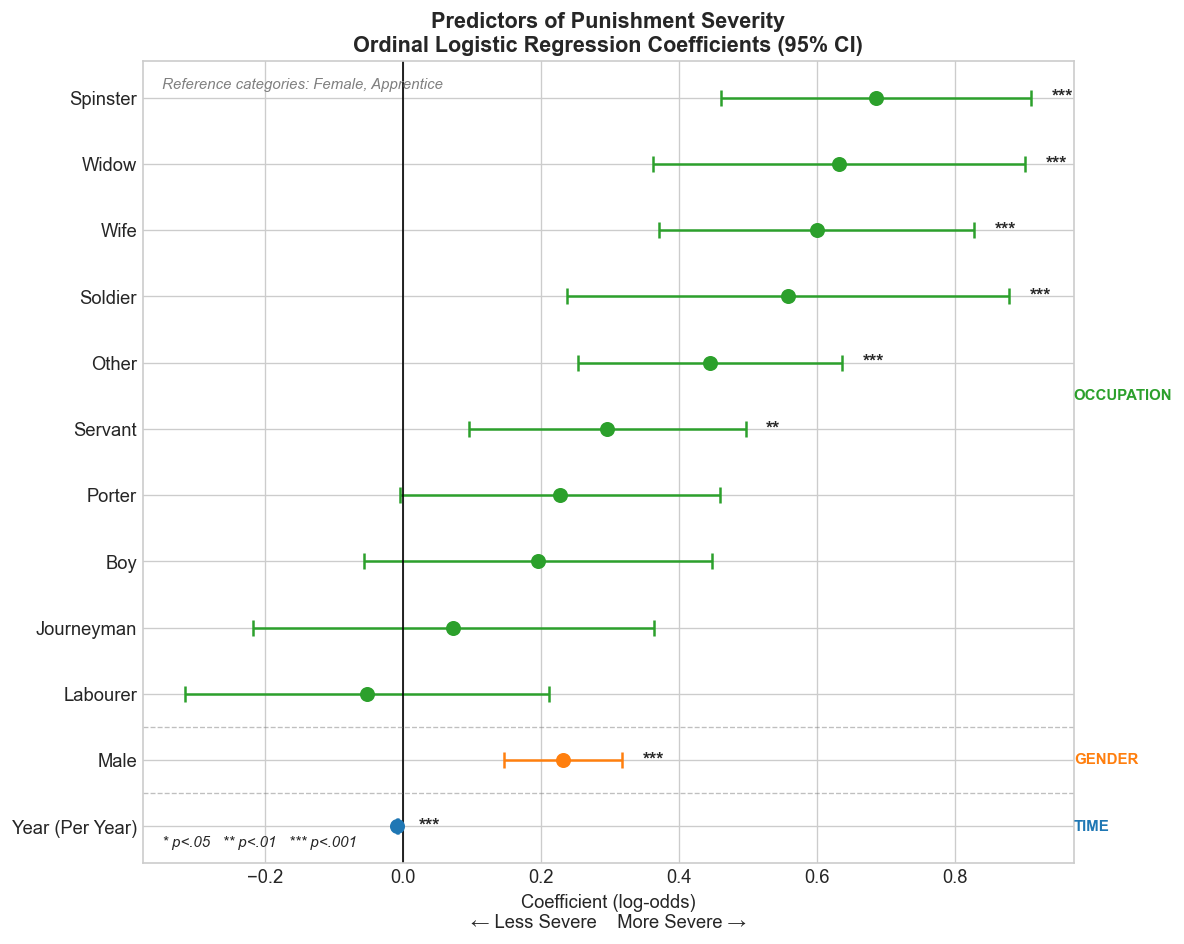

In [13]:
# Right, time to make something that actually looks professional.
# A forest plot showing our coefficients with confidence intervals, grouped by predictor type.
# If a fragment of data falls in a forest plot and no one hears
# Did it really fall? 


# First, let's separate our predictors into their natural groupings
# This makes the plot actually readable instead of a jumbled mess
# We're using list comprehension here.
# It loops through da_results.index and keeps only items containing 'gender'
# It's equivalent to writing a for loop and appending to a list, just more compact
the_gender_coefficients = [idx for idx in da_results.index if 'gender' in idx]
the_occupation_coefficients = [idx for idx in da_results.index if 'occupation' in idx]
the_year_coefficients = [idx for idx in da_results.index if 'year' in idx]


# These raw variable names are hideous on a plot
# HIDEOUS I tell you
# "defendant_gender_male" tells statisticians what it is, but normal humans deserve better. 
# Utter woke brilliance <3

def make_it_readable(ugly_name):
    # .replace() swaps one string for another
    # We're stripping out the prefixes that pandas added when creating dummy variables
    ugly_name = ugly_name.replace("defendant_gender_", "")
    ugly_name = ugly_name.replace("occupation_grouped_", "")
    ugly_name = ugly_name.replace("session_year_centred", "Year (per year)")
    # .title() capitalises the first letter of each word - "labourer" becomes "Labourer"
    # WAIT, LABOUR?!
    return ugly_name.title()


# Now we order everything sensibly: Year at the bottom, then Gender, then Occupations
# Occupations get sorted by their coefficient so you can see the gradient
# It's a small touch but we like to tell stories here <3

# sorted() lets us sort by something other than alphabetical
# Here we're sorting occupation names by their coefficient value in da_results
ordered_for_glory = the_year_coefficients + the_gender_coefficients + sorted(the_occupation_coefficients, key=lambda x: da_results.loc[x, 'coef'])

plot_ready_df = da_results.loc[ordered_for_glory]


# YES, I LOVE COLOUR CODING
# Blue for time, orange for gender, green for occupation
# These are matplotlib's default colour cycle colours
colour_me_impressed = []
for variable in ordered_for_glory:
    if variable in the_year_coefficients:
        colour_me_impressed.append('#1f77b4')  # Blue
    elif variable in the_gender_coefficients:
        colour_me_impressed.append('#ff7f0e')  # Orange
    else:
        colour_me_impressed.append('#2ca02c')  # Green




# Right, let's actually bloody build this thing
fig, ax = plt.subplots(figsize=(10, 8))
y_positions = np.arange(len(plot_ready_df))


# Plot each coefficient as a dot with error bars
for i, (idx, row) in enumerate(plot_ready_df.iterrows()):
    # ax.errorbar() plots a point with error bars extending from it
    # This is THE function for forest plots
    # It works so I don't have to
    ax.errorbar(
        x=row['coef'],            # x-position is the coefficient value
        y=i,                      # y-position is just 0, 1, 2, 3... (our row number)
        xerr=1.96 * row['se'],    # error bar length: 1.96 * standard error = 95% CI
                                  # Why 1.96? It's the z-score for 95% confidence in a normal distribution
                                  
        fmt='o',                  
        color=colour_me_impressed[i],
        markersize=8,             # how big the damn dot is
        capsize=5,                # the little sugoi horizontal lines at the end of error bars
        capthick=1.5,             
        elinewidth=1.5            # The tasteful thickness of it...
    )
    
    # Significance stars because academics LOVE their asterisks 
    # Thank you quick google search
    # Three stars for the big guns, two for pretty good, one for ehhhh you suck
    well_how_significant_is_it = '***' if row['p'] < 0.001 else '**' if row['p'] < 0.01 else '*' if row['p'] < 0.05 else ''
    
    if well_how_significant_is_it:
        ax.annotate(well_how_significant_is_it, (row['coef'] + 1.96*row['se'] + 0.03, i), 
                    va='center',          
                    fontsize=11, 
                    fontweight='bold')


# The vertical line at zero, if your CI crosses this, your effect isn't significant lol!
# I call it the "do you matter" line
ax.axvline(0, color='black', linewidth=1, linestyle='-')


# Now let's do all our positioning for our labels and more
ax.set_yticks(y_positions)
ax.set_yticklabels([make_it_readable(n) for n in plot_ready_df.index])

ax.axhline(len(the_year_coefficients) - 0.5, color='grey', linewidth=0.8, linestyle='--', alpha=0.5)
ax.axhline(len(the_year_coefficients) + len(the_gender_coefficients) - 0.5, color='grey', linewidth=0.8, linestyle='--', alpha=0.5)

ax.annotate('TIME', xy=(ax.get_xlim()[1], len(the_year_coefficients)/2 - 0.5), 
            fontsize=9, fontweight='bold', color='#1f77b4', va='center')
ax.annotate('GENDER', xy=(ax.get_xlim()[1], len(the_year_coefficients) + len(the_gender_coefficients)/2 - 0.5), 
            fontsize=9, fontweight='bold', color='#ff7f0e', va='center')
ax.annotate('OCCUPATION', xy=(ax.get_xlim()[1], len(the_year_coefficients) + len(the_gender_coefficients) + len(the_occupation_coefficients)/2 - 0.5), 
            fontsize=9, fontweight='bold', color='#2ca02c', va='center')

ax.set_xlabel('Coefficient (log-odds)\n← Less Severe    More Severe →', fontsize=11)
ax.set_title('Predictors of Punishment Severity\nOrdinal Logistic Regression Coefficients (95% CI)', 
             fontsize=13, fontweight='bold')


# Footnotes for the pedants (affectionate)
ax.text(0.02, 0.02, '* p<.05   ** p<.01   *** p<.001', 
        transform=ax.transAxes, fontsize=9, style='italic')

# Reference category note - crucial for interpretation
# Without this, people might wonder "where's female? where's apprentice?"
# When we made dummy variables with drop_first=True, the first category became the reference
# All coefficients are relative to being female and being an apprentice
ax.text(0.02, 0.98, 'Reference categories: Female, Apprentice', 
        transform=ax.transAxes, fontsize=9, style='italic', va='top', color='grey')

plt.tight_layout()

plt.savefig('forest_plot.png', dpi=150, bbox_inches='tight')
plt.show()

#### Results

We can firmly say, we reject the null hypothesis. Defendant gender, occupation, and year of trial all significantly predict punishment severity at the Old Bailey (Likelihood Ratio Test: χ² = 428.3, p < 0.001). Again, note that significant does not mean good, it just means it isn't nothing. 

##### Time
Punishment severity decreased over the 160-year period, though realistically, the effect is small. Each passing year reduced the odds of receiving a more severe punishment by approximately 0.8% (OR = 0.992, 95% CI [0.991, 0.993], p < 0.001). This translates to meaningful change over the long term.

A defendant in 1834 faced roughly 73% the odds of severe punishment compared to an equivalent defendant in 1674. The time series visualisation corroborates this, showing a general decline from mean severity ~4.0 in the mid-18th century to ~3.0 by the 1830s, potentially reflecting Enlightenment-era penal reform and the growing preference for imprisonment over transportation and capital punishment. Australia stopped being a penal colony in 1868 with the last convoy ship, so the idea was on its way out by the time of our dataset at the very least. In addition, better policing (Bow Street Runners, 1749, then the Peace Preservation Act of 1814) likely meant crime was being committed less. Plus, the advent of larger cities and better methods of space efficiency likely meant imprisonment became more common over transportation. 

##### Gender
Male defendants faced 26% higher odds of more severe punishment compared to females (OR = 1.26, 95% CI [1.16, 1.37], p < 0.001). 

However, this coefficient should be interpreted cautiously given the proportional odds violation identified earlier in our assumption section. The threshold-specific analysis revealed that men were actually less likely to receive any punishment versus acquittal (β = -0.387) but substantially more likely to receive death versus lesser punishments (β = 0.669). 

The aggregate hides a lot. Courts may have acquitted men more readily at the lower end while reserving the harshest sentences for them at the top, which possibly fits in a patriarchal view of society. 

##### Occupation 
Occupational category significantly predicted punishment severity, though the pattern defies simple interpretation. Relative to apprentices (the reference category), female-coded occupations received the harshest punishments: spinsters (OR = 1.99, 95% CI [1.59, 2.49], p < 0.001), widows (OR = 1.88, 95% CI [1.44, 2.46], p < 0.001), and wives (OR = 1.82, 95% CI [1.45, 2.29], p < 0.001). Soldiers also received notably severe sentences (OR = 1.75, 95% CI [1.27, 2.41], p < 0.001).

At first glance, one would think this somewhat appears to contradict the gender finding. After all, if women received lighter sentences, why do female occupations cluster at the harsh end? The resolution likely lies in punishment type rather than severity per se. Figure 1 shows women were disproportionately transported rather than imprisoned or corporally punished. On our severity scale, transportation (4) ranks above imprisonment (3) and corporal punishment (2), inflating the apparent severity for female defendants. Whether transportation to the colonies was genuinely "worse" than imprisonment is debatable, and realistically shows a limitation of our ordinal ranking.

But I think there is something more to it potentially. It's also worth noting that female 'occupations' in this dataset are largely marital statuses (spinster, widow, wife) rather than trades, which have an extreme amount of variety as one can see from our other hypotheses and the dataframes we created. This is likely a reflection of how women were simply categorised in the period. So, we do have some limits on direct comparison with male occupational categories and it means our occupation variable captures different information depending on defendant gender; though this isn't necessarily the case. Mostly, we have to take the data as is. 

Regardless, labourers, journeymen, boys, and porters showed no significant difference from apprentices (all p > 0.05), their confidence intervals crossing zero in the forest plot. The occupational hierarchy of punishment severity does not map neatly onto social class, after all, manual labourers were not punished more harshly than skilled tradespeople. 

There's a lot of information there. What do we conclude?

#### Conclusion

We find strong evidence that punishment at the Old Bailey was not applied uniformly. Gender, occupation, and time period all significantly predicted sentencing severity, leading us to reject the null hypothesis that these characteristics had no effect.

The results partially support historical accounts of judicial paternalism, but with important nuance. Male defendants faced higher odds of severe punishment overall. Yet, this average effect conceals a more complex pattern revealed by our assumption testing. Men were more likely to be acquitted outright but, once convicted, faced disproportionately harsh sentences at the extreme end. This is consistent with academic observation that women received fewer immediate imprisonments while complicating any simple narrative of female leniency.

The occupational findings are more ambiguous. Female-coded occupations (spinster, widow, wife) received the highest severity scores, driven largely by the predominance of transportation sentences for women. This raises questions about our severity ranking: is transportation genuinely more severe than imprisonment, or are we imposing a modern hierarchy that contemporaries would not have recognised? Future work might explore alternative operationalisations of punishment severity, perhaps incorporating sentence length or contemporary legal distinctions.

Several limitations constrain our conclusions. First, the proportional odds assumption was violated for gender, meaning the ordinal regression coefficient represents an average across heterogeneous threshold-specific effects. We retained the model for interpretability but acknowledge this smooths over real complexity. Second, the Old Bailey records represent only cases that reached trial in London's central criminal court, so not all crime, not all courts, and not all outcomes. Selection effects likely bias our sample in ways we quite literally cannot fully account for. Lastly, occupational categories evolved over the 160-year period; "labourer" in 1680 may not be equivalent to "labourer" in 1830. And even crime definitions can change. This is why, under any temporal analysis, murder is best to use as it is a fixed definition. 

But, perhaps for next time. 

Despite these limitations, the analysis demonstrates that defendant characteristics predicted judicial outcomes in Georgian and early Victorian England. 

Justice, at least as recorded in the Old Bailey proceedings, was not blind to who stood in the dock...

# Visualising

## Interactive Predictor

You can explore these patterns interactively with our [Old Bailey Punishment Predictor app](http://127.0.0.1:8000)

(Note: Run `shiny run app.py` in the terminal to start the app)